In [1]:
# import sys 
# sys.path
# sys.path.append("~/anaconda3/lib/python3.8/site-packages/tensorflow_estimator")
# sys.path
# import tensorflow as tf
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from sklearn.metrics import accuracy_score
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1,2'

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 20 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 45 # the number of class
        self.feat_d = 190
        self.filters = 64
        self.data_dir = '/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/data/FPHAB/'
C = Config()

# Building the model

In [4]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=20,joint_d=3,feat_d=231,filters=64):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [5]:
def build_DD_Net(frame_l=32,joint_n=20,joint_d=3,feat_d=231,clc_num=45,filters=64):
    M = Input(name='M', shape=(frame_l,feat_d))   #32,231
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) #32,22,3
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters) #32,22,3,231,16
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters) #32,22,3,231,14,64

In [7]:
DD_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 190)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 20, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 512)       1733376     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           model_1[1][0]              

## load data

In [8]:
Train = pickle.load(open(C.data_dir+"train_130.pkl", "rb"))
# print('Train',Train)
Test = pickle.load(open(C.data_dir+"test_130.pkl", "rb"))

## Without frame_sampling train

In [9]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,20,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['label'][i]-1] = 1  

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  #(1960,32,231) ndarray
X_1 = np.stack(X_1)  #(1960,32,22,3)
Y = np.stack(Y)

100%|████████████████████████████████████████| 392/392 [00:03<00:00, 121.29it/s]


In [11]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,20,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|████████████████████████████████████████| 783/783 [00:06<00:00, 126.22it/s]


In [12]:
# it may takes several times to reach the reported performance
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y, 
            batch_size=len(Y),
            epochs=600, #600
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 392 samples, validate on 783 samples
Epoch 1/600
392/392 [==============================] - 6s 15ms/step - loss: 4.5308 - accuracy: 0.0204 - val_loss: 4.8058 - val_accuracy: 0.0255
Epoch 2/600
392/392 [==============================] - 0s 243us/step - loss: 4.2005 - accuracy: 0.0485 - val_loss: 5.0357 - val_accuracy: 0.0255
Epoch 3/600
392/392 [==============================] - 0s 243us/step - loss: 3.9692 - accuracy: 0.0638 - val_loss: 5.4331 - val_accuracy: 0.0421
Epoch 4/600
392/392 [==============================] - 0s 244us/step - loss: 3.8517 - accuracy: 0.0867 - val_loss: 5.7428 - val_accuracy: 0.0434
Epoch 5/600
392/392 [==============================] - 0s 247us/step - loss: 3.6387 - accuracy: 0.0689 - val_loss: 6.1002 - val_accuracy: 0.0319
Epoch 6/600
392/392 [==============================] - 0s 246us/step - loss: 3.5533 - accuracy: 0.0893 - val_loss: 6.6330 - val_accuracy: 0.0243
Epoch 7/600
392/392 [==============================] - 0s 244us/step - loss: 3.4326 -

Epoch 57/600
392/392 [==============================] - 0s 256us/step - loss: 1.0160 - accuracy: 0.8087 - val_loss: 3.6311 - val_accuracy: 0.1162
Epoch 58/600
392/392 [==============================] - 0s 276us/step - loss: 1.0272 - accuracy: 0.8010 - val_loss: 3.6242 - val_accuracy: 0.1162
Epoch 59/600
392/392 [==============================] - 0s 261us/step - loss: 1.0201 - accuracy: 0.7832 - val_loss: 3.6377 - val_accuracy: 0.1137
Epoch 60/600
392/392 [==============================] - 0s 257us/step - loss: 0.9586 - accuracy: 0.8214 - val_loss: 3.6754 - val_accuracy: 0.1111
Epoch 61/600
392/392 [==============================] - 0s 257us/step - loss: 0.9370 - accuracy: 0.8291 - val_loss: 3.7450 - val_accuracy: 0.1047
Epoch 62/600
392/392 [==============================] - 0s 257us/step - loss: 0.9064 - accuracy: 0.8444 - val_loss: 3.7988 - val_accuracy: 0.0983
Epoch 63/600
392/392 [==============================] - 0s 267us/step - loss: 0.9022 - accuracy: 0.8214 - val_loss: 3.8477 -

392/392 [==============================] - 0s 266us/step - loss: 0.3187 - accuracy: 0.9745 - val_loss: 2.5564 - val_accuracy: 0.3895
Epoch 114/600
392/392 [==============================] - 0s 252us/step - loss: 0.2697 - accuracy: 0.9770 - val_loss: 2.5636 - val_accuracy: 0.3921
Epoch 115/600
392/392 [==============================] - 0s 245us/step - loss: 0.2753 - accuracy: 0.9796 - val_loss: 2.5498 - val_accuracy: 0.3985
Epoch 116/600
392/392 [==============================] - 0s 243us/step - loss: 0.2676 - accuracy: 0.9821 - val_loss: 2.5294 - val_accuracy: 0.4074
Epoch 117/600
392/392 [==============================] - 0s 237us/step - loss: 0.3106 - accuracy: 0.9719 - val_loss: 2.5300 - val_accuracy: 0.4061
Epoch 118/600
392/392 [==============================] - 0s 258us/step - loss: 0.2595 - accuracy: 0.9898 - val_loss: 2.4906 - val_accuracy: 0.4189
Epoch 119/600
392/392 [==============================] - 0s 236us/step - loss: 0.2912 - accuracy: 0.9643 - val_loss: 2.4753 - val_ac

Epoch 169/600
392/392 [==============================] - 0s 252us/step - loss: 0.1788 - accuracy: 0.9949 - val_loss: 1.0410 - val_accuracy: 0.7420
Epoch 170/600
392/392 [==============================] - 0s 259us/step - loss: 0.1848 - accuracy: 0.9847 - val_loss: 1.0245 - val_accuracy: 0.7484
Epoch 171/600
392/392 [==============================] - 0s 264us/step - loss: 0.2311 - accuracy: 0.9796 - val_loss: 1.0106 - val_accuracy: 0.7510
Epoch 172/600
392/392 [==============================] - 0s 252us/step - loss: 0.1906 - accuracy: 0.9923 - val_loss: 0.9967 - val_accuracy: 0.7522
Epoch 173/600
392/392 [==============================] - 0s 256us/step - loss: 0.2127 - accuracy: 0.9847 - val_loss: 0.9842 - val_accuracy: 0.7522
Epoch 174/600
392/392 [==============================] - 0s 265us/step - loss: 0.2081 - accuracy: 0.9847 - val_loss: 0.9702 - val_accuracy: 0.7573
Epoch 175/600
392/392 [==============================] - 0s 255us/step - loss: 0.2182 - accuracy: 0.9847 - val_loss: 0

Epoch 225/600
392/392 [==============================] - 0s 244us/step - loss: 0.1794 - accuracy: 0.9923 - val_loss: 0.5610 - val_accuracy: 0.8659
Epoch 226/600
392/392 [==============================] - 0s 277us/step - loss: 0.1783 - accuracy: 0.9923 - val_loss: 0.5571 - val_accuracy: 0.8659
Epoch 227/600
392/392 [==============================] - 0s 251us/step - loss: 0.1963 - accuracy: 0.9949 - val_loss: 0.5533 - val_accuracy: 0.8685
Epoch 228/600
392/392 [==============================] - 0s 257us/step - loss: 0.1862 - accuracy: 0.9923 - val_loss: 0.5497 - val_accuracy: 0.8710
Epoch 229/600
392/392 [==============================] - 0s 256us/step - loss: 0.1962 - accuracy: 0.9923 - val_loss: 0.5461 - val_accuracy: 0.8723
Epoch 230/600
392/392 [==============================] - 0s 264us/step - loss: 0.2021 - accuracy: 0.9898 - val_loss: 0.5426 - val_accuracy: 0.8723
Epoch 231/600
392/392 [==============================] - 0s 253us/step - loss: 0.2147 - accuracy: 0.9796 - val_loss: 0

Epoch 281/600
392/392 [==============================] - 0s 272us/step - loss: 0.1982 - accuracy: 0.9923 - val_loss: 0.4398 - val_accuracy: 0.8863
Epoch 282/600
392/392 [==============================] - 0s 270us/step - loss: 0.2119 - accuracy: 0.9821 - val_loss: 0.4388 - val_accuracy: 0.8889
Epoch 283/600
392/392 [==============================] - 0s 265us/step - loss: 0.1860 - accuracy: 0.9898 - val_loss: 0.4377 - val_accuracy: 0.8889
Epoch 284/600
392/392 [==============================] - 0s 278us/step - loss: 0.1933 - accuracy: 0.9872 - val_loss: 0.4367 - val_accuracy: 0.8889
Epoch 285/600
392/392 [==============================] - 0s 287us/step - loss: 0.2326 - accuracy: 0.9872 - val_loss: 0.4355 - val_accuracy: 0.8889
Epoch 286/600
392/392 [==============================] - 0s 261us/step - loss: 0.2318 - accuracy: 0.9796 - val_loss: 0.4345 - val_accuracy: 0.8889
Epoch 287/600
392/392 [==============================] - 0s 291us/step - loss: 0.2179 - accuracy: 0.9770 - val_loss: 0

Epoch 337/600
392/392 [==============================] - 0s 257us/step - loss: 0.2165 - accuracy: 0.9872 - val_loss: 0.4030 - val_accuracy: 0.8953
Epoch 338/600
392/392 [==============================] - 0s 241us/step - loss: 0.2065 - accuracy: 0.9974 - val_loss: 0.4026 - val_accuracy: 0.8953
Epoch 339/600
392/392 [==============================] - 0s 265us/step - loss: 0.2071 - accuracy: 0.9847 - val_loss: 0.4023 - val_accuracy: 0.8953
Epoch 340/600
392/392 [==============================] - 0s 267us/step - loss: 0.1977 - accuracy: 0.9847 - val_loss: 0.4019 - val_accuracy: 0.8953
Epoch 341/600
392/392 [==============================] - 0s 256us/step - loss: 0.1830 - accuracy: 0.9949 - val_loss: 0.4016 - val_accuracy: 0.8953
Epoch 342/600
392/392 [==============================] - 0s 258us/step - loss: 0.2201 - accuracy: 0.9898 - val_loss: 0.4012 - val_accuracy: 0.8953
Epoch 343/600
392/392 [==============================] - 0s 268us/step - loss: 0.2039 - accuracy: 0.9872 - val_loss: 0

Epoch 393/600
392/392 [==============================] - 0s 264us/step - loss: 0.2259 - accuracy: 0.9796 - val_loss: 0.3898 - val_accuracy: 0.9004
Epoch 394/600
392/392 [==============================] - 0s 250us/step - loss: 0.1992 - accuracy: 0.9872 - val_loss: 0.3896 - val_accuracy: 0.9004
Epoch 395/600
392/392 [==============================] - 0s 255us/step - loss: 0.2280 - accuracy: 0.9898 - val_loss: 0.3895 - val_accuracy: 0.9004
Epoch 396/600
392/392 [==============================] - 0s 288us/step - loss: 0.2199 - accuracy: 0.9898 - val_loss: 0.3893 - val_accuracy: 0.9004
Epoch 397/600
392/392 [==============================] - 0s 261us/step - loss: 0.2372 - accuracy: 0.9770 - val_loss: 0.3892 - val_accuracy: 0.9017
Epoch 398/600
392/392 [==============================] - 0s 256us/step - loss: 0.1979 - accuracy: 0.9821 - val_loss: 0.3891 - val_accuracy: 0.9017
Epoch 399/600
392/392 [==============================] - 0s 253us/step - loss: 0.2127 - accuracy: 0.9821 - val_loss: 0

Epoch 449/600
392/392 [==============================] - 0s 269us/step - loss: 0.1809 - accuracy: 0.9872 - val_loss: 0.3847 - val_accuracy: 0.9017
Epoch 450/600
392/392 [==============================] - 0s 267us/step - loss: 0.2003 - accuracy: 0.9796 - val_loss: 0.3846 - val_accuracy: 0.9017
Epoch 451/600
392/392 [==============================] - 0s 273us/step - loss: 0.1892 - accuracy: 0.9923 - val_loss: 0.3845 - val_accuracy: 0.9029
Epoch 452/600
392/392 [==============================] - 0s 254us/step - loss: 0.1877 - accuracy: 0.9898 - val_loss: 0.3843 - val_accuracy: 0.9017
Epoch 453/600
392/392 [==============================] - 0s 259us/step - loss: 0.2036 - accuracy: 0.9847 - val_loss: 0.3842 - val_accuracy: 0.9029
Epoch 454/600
392/392 [==============================] - 0s 254us/step - loss: 0.2042 - accuracy: 0.9821 - val_loss: 0.3841 - val_accuracy: 0.9029
Epoch 455/600
392/392 [==============================] - 0s 265us/step - loss: 0.2034 - accuracy: 0.9923 - val_loss: 0

Epoch 505/600
392/392 [==============================] - 0s 254us/step - loss: 0.2259 - accuracy: 0.9745 - val_loss: 0.3816 - val_accuracy: 0.9068
Epoch 506/600
392/392 [==============================] - 0s 249us/step - loss: 0.1947 - accuracy: 0.9872 - val_loss: 0.3816 - val_accuracy: 0.9068
Epoch 507/600
392/392 [==============================] - 0s 261us/step - loss: 0.1929 - accuracy: 0.9923 - val_loss: 0.3815 - val_accuracy: 0.9068
Epoch 508/600
392/392 [==============================] - 0s 253us/step - loss: 0.1924 - accuracy: 0.9847 - val_loss: 0.3815 - val_accuracy: 0.9042
Epoch 509/600
392/392 [==============================] - 0s 262us/step - loss: 0.1785 - accuracy: 0.9872 - val_loss: 0.3814 - val_accuracy: 0.9042
Epoch 510/600
392/392 [==============================] - 0s 256us/step - loss: 0.2025 - accuracy: 0.9872 - val_loss: 0.3813 - val_accuracy: 0.9042
Epoch 511/600
392/392 [==============================] - 0s 268us/step - loss: 0.2050 - accuracy: 0.9949 - val_loss: 0

Epoch 561/600
392/392 [==============================] - 0s 269us/step - loss: 0.1911 - accuracy: 0.9949 - val_loss: 0.3804 - val_accuracy: 0.9055
Epoch 562/600
392/392 [==============================] - 0s 270us/step - loss: 0.1848 - accuracy: 0.9847 - val_loss: 0.3803 - val_accuracy: 0.9068
Epoch 563/600
392/392 [==============================] - 0s 259us/step - loss: 0.2104 - accuracy: 0.9796 - val_loss: 0.3803 - val_accuracy: 0.9068
Epoch 564/600
392/392 [==============================] - 0s 263us/step - loss: 0.2055 - accuracy: 0.9923 - val_loss: 0.3803 - val_accuracy: 0.9068
Epoch 565/600
392/392 [==============================] - 0s 253us/step - loss: 0.1951 - accuracy: 0.9923 - val_loss: 0.3803 - val_accuracy: 0.9068
Epoch 566/600
392/392 [==============================] - 0s 266us/step - loss: 0.1855 - accuracy: 0.9898 - val_loss: 0.3803 - val_accuracy: 0.9068
Epoch 567/600
392/392 [==============================] - 0s 250us/step - loss: 0.2105 - accuracy: 0.9770 - val_loss: 0

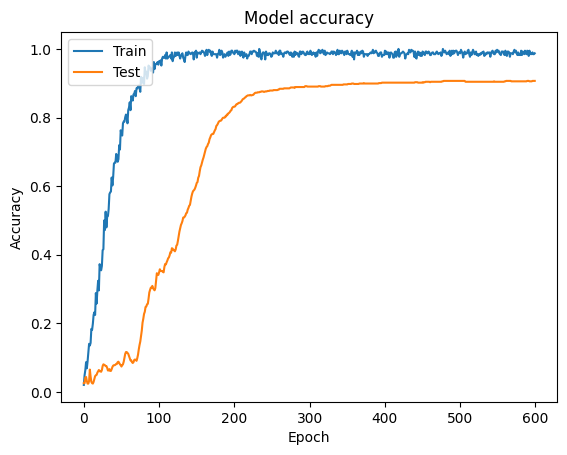

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLDDNet_130_test1.png")
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
# DD_Net.save_weights('weights/coarse_heavy.h1')

In [15]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [16]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [17]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9067688378033205


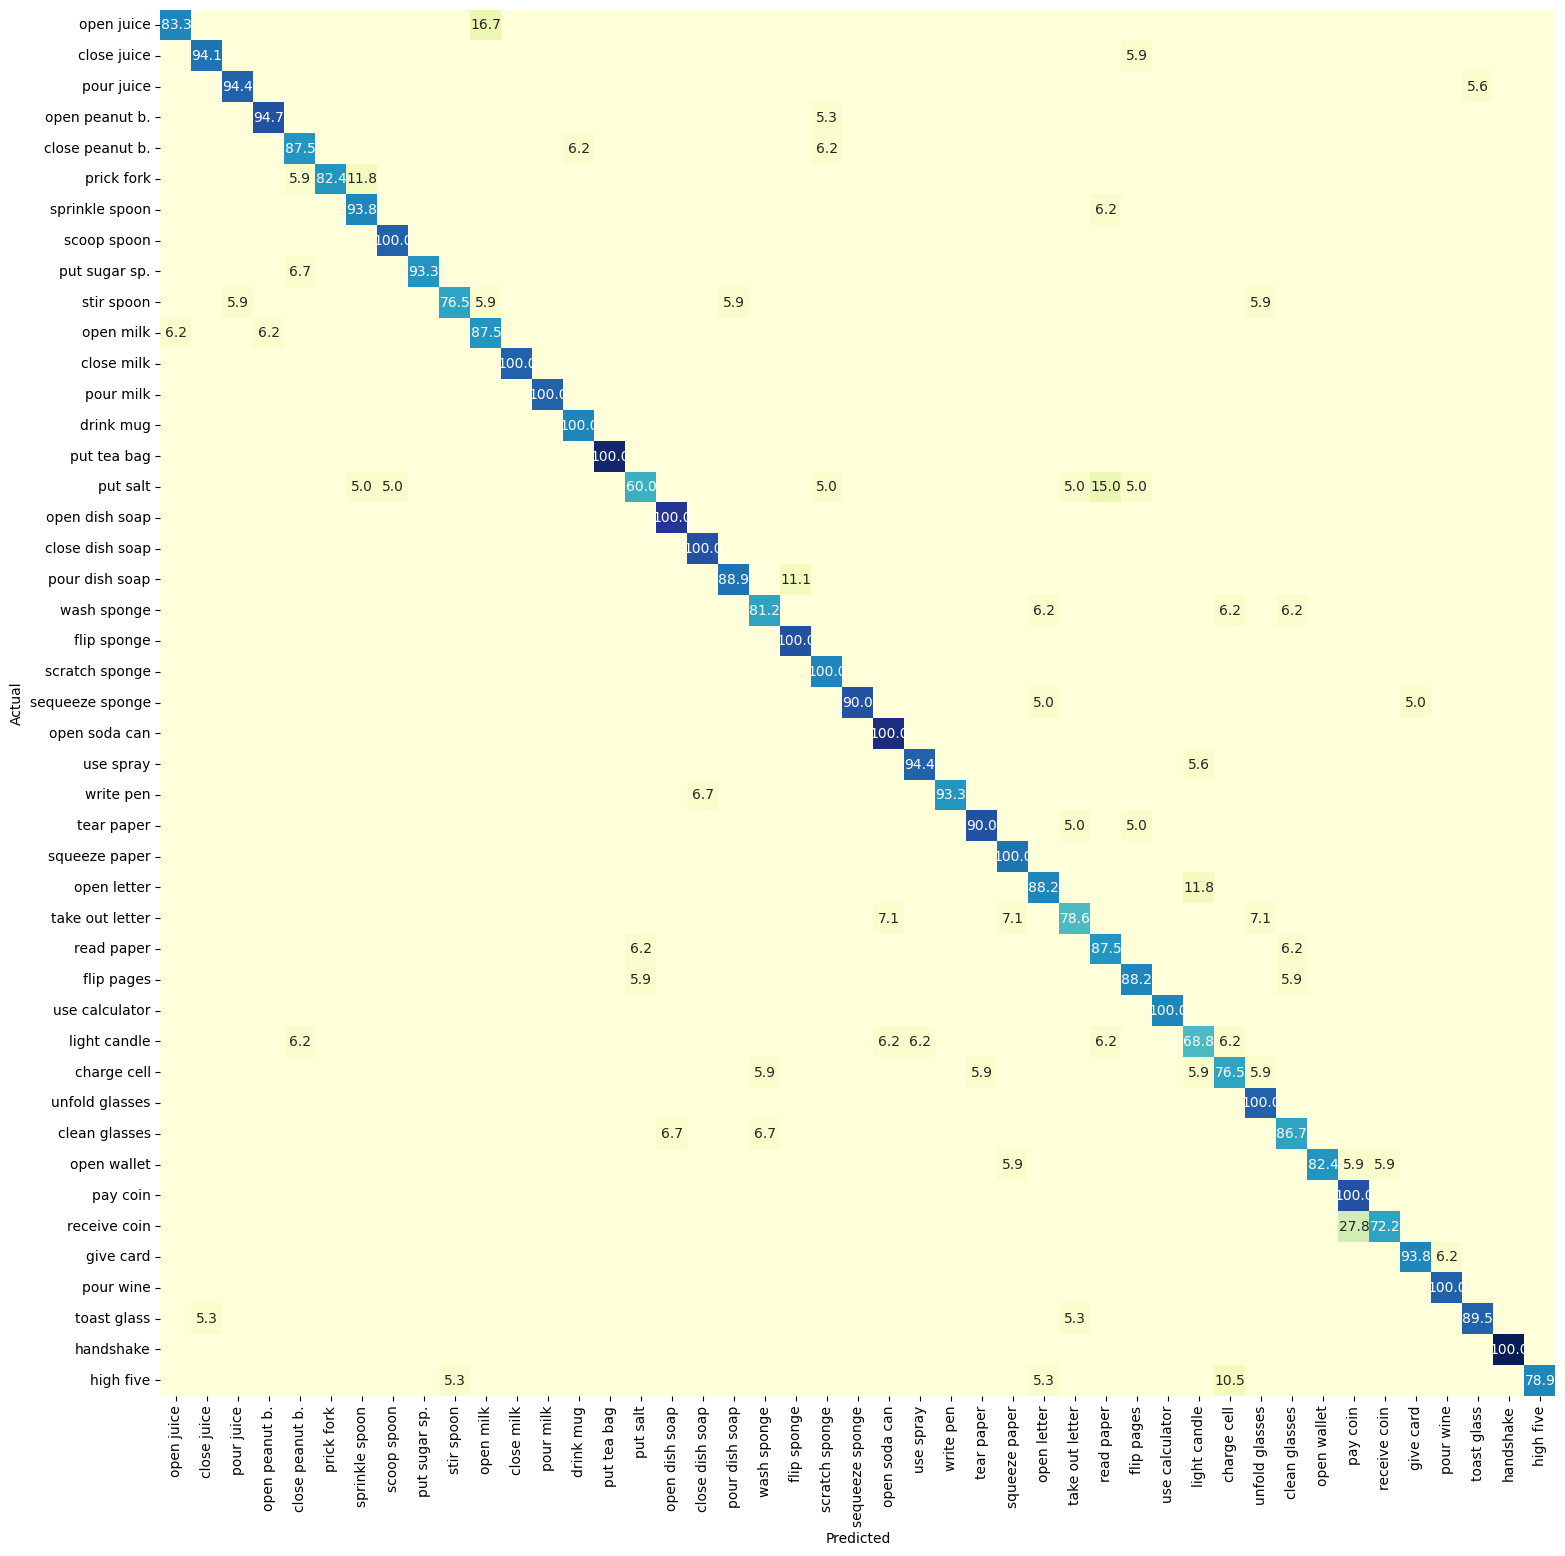

In [18]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_130_test2.png', labels, ymap=None, figsize=(18,18))

## Training with frame_sampling

In [19]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])

In [20]:
epochs = 20  #20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    
        label = np.zeros(C.clc_coarse)
        label[Train['label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,20,3])
        p = sampling_frame(p,C)
       
        p = normlize_range(p)
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net_model = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

epoch0


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 125.07it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 4s 10ms/step - loss: 0.2303 - accuracy: 0.9923 - val_loss: 0.3792 - val_accuracy: 0.9080
epoch1


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 123.73it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 244us/step - loss: 0.2133 - accuracy: 0.9974 - val_loss: 0.3790 - val_accuracy: 0.9080
epoch2


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 123.06it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 274us/step - loss: 0.2167 - accuracy: 0.9872 - val_loss: 0.3788 - val_accuracy: 0.9093
epoch3


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 127.93it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 235us/step - loss: 0.2002 - accuracy: 0.9847 - val_loss: 0.3786 - val_accuracy: 0.9093
epoch4


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 123.56it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 240us/step - loss: 0.2177 - accuracy: 0.9796 - val_loss: 0.3785 - val_accuracy: 0.9093
epoch5


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 122.52it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 241us/step - loss: 0.2179 - accuracy: 0.9668 - val_loss: 0.3782 - val_accuracy: 0.9093
epoch6


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 122.15it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 241us/step - loss: 0.2221 - accuracy: 0.9821 - val_loss: 0.3781 - val_accuracy: 0.9093
epoch7


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 125.38it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 227us/step - loss: 0.2025 - accuracy: 0.9923 - val_loss: 0.3780 - val_accuracy: 0.9093
epoch8


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 120.51it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 248us/step - loss: 0.2049 - accuracy: 0.9770 - val_loss: 0.3779 - val_accuracy: 0.9093
epoch9


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 121.29it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 260us/step - loss: 0.2213 - accuracy: 0.9694 - val_loss: 0.3778 - val_accuracy: 0.9093
epoch10


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 124.51it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 237us/step - loss: 0.2243 - accuracy: 0.9745 - val_loss: 0.3776 - val_accuracy: 0.9093
epoch11


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 119.43it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 249us/step - loss: 0.1962 - accuracy: 0.9847 - val_loss: 0.3776 - val_accuracy: 0.9093
epoch12


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 126.85it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 242us/step - loss: 0.2067 - accuracy: 0.9847 - val_loss: 0.3774 - val_accuracy: 0.9093
epoch13


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 127.92it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 265us/step - loss: 0.2109 - accuracy: 0.9821 - val_loss: 0.3773 - val_accuracy: 0.9093
epoch14


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 129.27it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 238us/step - loss: 0.2051 - accuracy: 0.9898 - val_loss: 0.3771 - val_accuracy: 0.9093
epoch15


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 120.84it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 232us/step - loss: 0.2269 - accuracy: 0.9770 - val_loss: 0.3770 - val_accuracy: 0.9093
epoch16


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 123.97it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 238us/step - loss: 0.1922 - accuracy: 0.9949 - val_loss: 0.3770 - val_accuracy: 0.9080
epoch17


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 120.82it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 259us/step - loss: 0.2160 - accuracy: 0.9668 - val_loss: 0.3769 - val_accuracy: 0.9080
epoch18


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 124.97it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 256us/step - loss: 0.2094 - accuracy: 0.9872 - val_loss: 0.3768 - val_accuracy: 0.9068
epoch19


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 127.35it/s]


Train on 392 samples, validate on 783 samples
Epoch 1/1
392/392 [==============================] - 0s 248us/step - loss: 0.2182 - accuracy: 0.9821 - val_loss: 0.3768 - val_accuracy: 0.9068


# Plotting confusion matrix

In [21]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [22]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [23]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9067688378033205


In [ ]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_130_test3.png', labels, ymap=None, figsize=(18,18))

# Policy gradient for frame selection  -------train

In [25]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear,ReLU,CrossEntropyLoss,Sequential,Conv2d,MaxPool2d,Module,Softmax,BatchNorm2d,Dropout
from torch.optim import Adam,SGD

from numpy.random import default_rng
from utils import *

from numpy.random import default_rng


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

gamma = 0.7


class Policy(nn.Module):
    def __init__(self, n_states, n_actions, hidden_size, learning_rate=1e-4):
        super(Policy, self).__init__()

        self.n_actions = n_actions 

        self.cnn_layers = Sequential(Conv2d(1, 32, kernel_size=2),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(32, 64, kernel_size=3, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(64, 128, kernel_size=2, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),) 

        self.linear_layers = Sequential(
            Linear(7680,3)) #32 8448  #7680
#         optimizer = Adam(model.parameters(), lr=0.001)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = x.float()
        x = self.cnn_layers(x)
        # x=x.size
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.softmax(x, dim=1)
        return x 
    
    def select_action(self, state):  
        # state = torch.from_numpy(state).float().unsqueeze(0)
        pr = self.forward(Variable(state))   
        act = np.random.choice(self.n_actions, p=np.squeeze(pr.detach().numpy())) 
        log_pr = torch.log(pr.squeeze(0)[act]) 
        return act, log_pr
  
            
def update_policy(policy_network, rewards, log_probs): 
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        count = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**count * r    
            count +=count
        discounted_rewards.append(Gt)
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-4) 
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()


def calculate_reward(Probs, Probs_history , true_class): 
  ## Probs is the outcome of softmax layer from classifier CNN # Probs : N_classes * 1
  ## Probs_history i the output of previous iteration
  ## true_class is an integer from [1-10]
  ## iteration is the number of iterations passed from the beginning
  omega = 5 # a measure of how strong are the punishments and stimulations
  predicted_class = np.argmax(Probs) + 1
  prev_predicted_class = np.argmax(Probs_history) + 1  ## +1 is bcz classes are from 1 to 10
  
  
  if (predicted_class == true_class and not(prev_predicted_class == true_class) ):
    reward = omega  ## stimulation
  elif ( not(predicted_class == true_class) and (prev_predicted_class == true_class) ):
    reward = - omega ## punishment
  else:
    true_class = int(true_class)
    reward = (np.sign(Probs[true_class - 1]  - Probs_history[true_class - 1])) ## -1 is bcz classes are from 1 to 10

  return reward   

def train(oridata,labels): 
    n_states=32 
    n_actions=3 
    # env.seed(random_seed)
    policy_net = Policy(n_states, n_actions, 128) 
    max_episode_num =  1
    max_steps = 32  
    all_rewards = []
    label_new=[]
    final_ind=[]
    for episode in tqdm(range(max_episode_num)):        
        rewards2=[]
        x_tr=[]
        for v in tqdm(range(len(oridata))):
            log_probs = []
            rewards = []
            rng = default_rng()
            Action=[]
            if len(oridata[v])>=32:
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=False))   
            else:
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=True))  
            XX=oridata[v]  
            original_fr=XX.clone().detach()  
            original_label=labels[v].numpy()
            
            for steps in range(len(MM)):
                state = original_fr[MM[steps]]
                state = state.reshape(1, 1, 20, 3)
                state = torch.Tensor(state)
                action, log_prob = policy_net.select_action(state)
                Action.append(action)

                if action == 0 :
                    if steps == 0:
                        a = 0
                    else:
                        a = math.ceil(((MM[steps - 1]) + MM[steps]) / 2)
                    d = min(1, MM[steps] - a)
                    MM[steps] = MM[steps] - d
                if action == 1:
                    MM[steps] = MM[steps]
                if action == 2:
                    if steps == len(MM) - 1:
                        a = len(original_fr)
                    else:
                        a = math.ceil((MM[steps] + MM[steps + 1]) / 2)
                    d = min(1, a - MM[steps] - 1)
                    MM[steps] = MM[steps] + d

                xm1 = XX[MM]
                xmm = xm1
                q = np.array(xm1)
                q = zoom(q,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

                M = get_CG(q,C)  
                q = q.reshape(1,32,20,3)
                M = M.reshape(1,32,190)

                original_fr = XX
                output = DD_Net.predict([M,q])       
                prob = output
                prediction = np.argmax(output,axis=1)

                prob=prob[0]
                if (steps == 0):
                  reward = 1 if prediction==original_label else -1    
                else:
                  reward=calculate_reward(prob, Probs_history ,original_label)
                Probs_history=prob 
                log_probs.append(log_prob)
                rewards.append(reward)
            
                if steps==len(MM) - 1:
                    xm1_step = XX[MM]
            x_tr.append(xm1_step)
            rewards2.append(np.mean(rewards))
            update_policy(policy_net, rewards, log_probs)    
            label_new.append(original_label)
        x_tr = torch.stack(x_tr)

        if episode==max_episode_num-1:
          final_ind.append(Action)
            

        
        R=np.sum((rewards2))
        all_rewards.append(R)
 
    return all_rewards,x_tr,policy_net

/home/l/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
Train = pickle.load(open(C.data_dir+"train_130.pkl","rb"))

oridata = []

for i in tqdm(range(len(Train['pose']))):
    ori = np.copy(Train['pose'][i]).reshape([-1,20,3]) 
    ori = torch.tensor(ori)
    oridata.append(ori)
    
labels = [int(Train['label'][i]) for i in (range(len(Train['pose'])))]
labels = torch.Tensor(labels)
labels_original = labels

100%|██████████████████████████████████████| 392/392 [00:00<00:00, 26265.49it/s]


### epoch 1

In [27]:
all_rewards,x_trnew,policy_net=train(oridata,labels_original)

 49%|████████████████████                     | 192/392 [02:11<02:19,  1.44it/s]


 98%|████████████████████████████████████████▎| 386/392 [04:23<00:03,  1.76it/s]


100%|████████████████████████████████████████████| 1/1 [04:27<00:00, 267.21s/it]


[-12.15625]


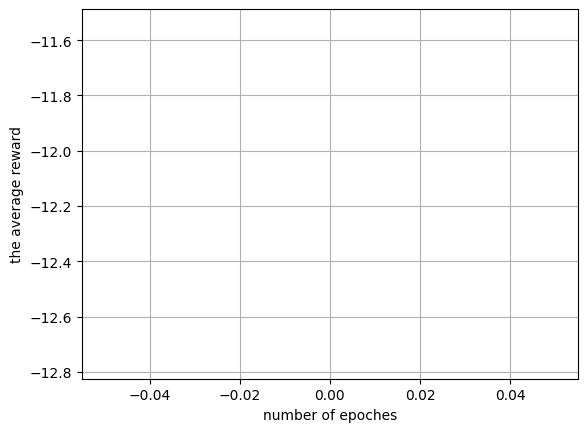

In [28]:
print(all_rewards)
plt.plot(all_rewards)
plt.xlabel('number of epoches')
plt.ylabel('the average reward')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLDDNet_130_test4_reward.png")
plt.grid()

In [29]:
X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew))):
    w_p = np.copy(x_trnew[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|████████████████████████████████████████| 392/392 [00:02<00:00, 131.37it/s]


In [30]:
# it may takes several times to reach the reported performance
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 392 samples, validate on 783 samples
Epoch 1/600
392/392 [==============================] - 4s 11ms/step - loss: 0.3521 - accuracy: 0.9413 - val_loss: 0.5811 - val_accuracy: 0.8531
Epoch 2/600
392/392 [==============================] - 0s 232us/step - loss: 0.3956 - accuracy: 0.9388 - val_loss: 0.6202 - val_accuracy: 0.8429
Epoch 3/600
392/392 [==============================] - 0s 244us/step - loss: 0.3986 - accuracy: 0.9311 - val_loss: 0.6371 - val_accuracy: 0.8289
Epoch 4/600
392/392 [==============================] - 0s 257us/step - loss: 0.3543 - accuracy: 0.9490 - val_loss: 0.5789 - val_accuracy: 0.8467
Epoch 5/600
392/392 [==============================] - 0s 247us/step - loss: 0.3231 - accuracy: 0.9541 - val_loss: 0.5205 - val_accuracy: 0.8697
Epoch 6/600
392/392 [==============================] - 0s 257us/step - loss: 0.3587 - accuracy: 0.9490 - val_loss: 0.4672 - val_accuracy: 0.8838
Epoch 7/600
392/392 [==============================] - 0s 247us/step - loss: 0.3917 -

Epoch 57/600
392/392 [==============================] - 0s 282us/step - loss: 0.1214 - accuracy: 0.9923 - val_loss: 0.5037 - val_accuracy: 0.8659
Epoch 58/600
392/392 [==============================] - 0s 250us/step - loss: 0.1098 - accuracy: 0.9949 - val_loss: 0.5018 - val_accuracy: 0.8685
Epoch 59/600
392/392 [==============================] - 0s 242us/step - loss: 0.1107 - accuracy: 0.9949 - val_loss: 0.5001 - val_accuracy: 0.8672
Epoch 60/600
392/392 [==============================] - 0s 243us/step - loss: 0.1104 - accuracy: 0.9923 - val_loss: 0.4957 - val_accuracy: 0.8697
Epoch 61/600
392/392 [==============================] - 0s 244us/step - loss: 0.1117 - accuracy: 0.9923 - val_loss: 0.4909 - val_accuracy: 0.8736
Epoch 62/600
392/392 [==============================] - 0s 246us/step - loss: 0.1049 - accuracy: 0.9974 - val_loss: 0.4865 - val_accuracy: 0.8761
Epoch 63/600
392/392 [==============================] - 0s 254us/step - loss: 0.1355 - accuracy: 0.9872 - val_loss: 0.4829 -

392/392 [==============================] - 0s 269us/step - loss: 0.0997 - accuracy: 1.0000 - val_loss: 0.3638 - val_accuracy: 0.9106
Epoch 114/600
392/392 [==============================] - 0s 275us/step - loss: 0.1038 - accuracy: 0.9974 - val_loss: 0.3621 - val_accuracy: 0.9119
Epoch 115/600
392/392 [==============================] - 0s 248us/step - loss: 0.1038 - accuracy: 0.9923 - val_loss: 0.3606 - val_accuracy: 0.9119
Epoch 116/600
392/392 [==============================] - 0s 270us/step - loss: 0.1181 - accuracy: 0.9923 - val_loss: 0.3591 - val_accuracy: 0.9106
Epoch 117/600
392/392 [==============================] - 0s 244us/step - loss: 0.1137 - accuracy: 0.9949 - val_loss: 0.3577 - val_accuracy: 0.9106
Epoch 118/600
392/392 [==============================] - 0s 256us/step - loss: 0.0941 - accuracy: 0.9872 - val_loss: 0.3562 - val_accuracy: 0.9093
Epoch 119/600
392/392 [==============================] - 0s 235us/step - loss: 0.1119 - accuracy: 0.9898 - val_loss: 0.3548 - val_ac

Epoch 169/600
392/392 [==============================] - 0s 235us/step - loss: 0.0953 - accuracy: 0.9898 - val_loss: 0.3143 - val_accuracy: 0.9132
Epoch 170/600
392/392 [==============================] - 0s 239us/step - loss: 0.1037 - accuracy: 0.9949 - val_loss: 0.3138 - val_accuracy: 0.9132
Epoch 171/600
392/392 [==============================] - 0s 258us/step - loss: 0.1046 - accuracy: 1.0000 - val_loss: 0.3135 - val_accuracy: 0.9132
Epoch 172/600
392/392 [==============================] - 0s 240us/step - loss: 0.0915 - accuracy: 0.9949 - val_loss: 0.3131 - val_accuracy: 0.9106
Epoch 173/600
392/392 [==============================] - 0s 258us/step - loss: 0.1116 - accuracy: 0.9949 - val_loss: 0.3128 - val_accuracy: 0.9106
Epoch 174/600
392/392 [==============================] - 0s 275us/step - loss: 0.1109 - accuracy: 0.9974 - val_loss: 0.3125 - val_accuracy: 0.9106
Epoch 175/600
392/392 [==============================] - 0s 265us/step - loss: 0.1000 - accuracy: 0.9923 - val_loss: 0

Epoch 225/600
392/392 [==============================] - 0s 257us/step - loss: 0.1040 - accuracy: 0.9821 - val_loss: 0.3012 - val_accuracy: 0.9157
Epoch 226/600
392/392 [==============================] - 0s 275us/step - loss: 0.0979 - accuracy: 0.9923 - val_loss: 0.3010 - val_accuracy: 0.9157
Epoch 227/600
392/392 [==============================] - 0s 269us/step - loss: 0.1063 - accuracy: 0.9949 - val_loss: 0.3010 - val_accuracy: 0.9157
Epoch 228/600
392/392 [==============================] - 0s 262us/step - loss: 0.1079 - accuracy: 0.9949 - val_loss: 0.3008 - val_accuracy: 0.9157
Epoch 229/600
392/392 [==============================] - 0s 267us/step - loss: 0.0865 - accuracy: 1.0000 - val_loss: 0.3008 - val_accuracy: 0.9157
Epoch 230/600
392/392 [==============================] - 0s 266us/step - loss: 0.1040 - accuracy: 0.9923 - val_loss: 0.3007 - val_accuracy: 0.9157
Epoch 231/600
392/392 [==============================] - 0s 289us/step - loss: 0.1068 - accuracy: 0.9949 - val_loss: 0

Epoch 281/600
392/392 [==============================] - 0s 254us/step - loss: 0.0947 - accuracy: 0.9949 - val_loss: 0.2952 - val_accuracy: 0.9195
Epoch 282/600
392/392 [==============================] - 0s 266us/step - loss: 0.0986 - accuracy: 0.9974 - val_loss: 0.2951 - val_accuracy: 0.9195
Epoch 283/600
392/392 [==============================] - 0s 261us/step - loss: 0.0843 - accuracy: 1.0000 - val_loss: 0.2950 - val_accuracy: 0.9195
Epoch 284/600
392/392 [==============================] - 0s 250us/step - loss: 0.0854 - accuracy: 1.0000 - val_loss: 0.2950 - val_accuracy: 0.9195
Epoch 285/600
392/392 [==============================] - 0s 276us/step - loss: 0.0894 - accuracy: 0.9923 - val_loss: 0.2950 - val_accuracy: 0.9195
Epoch 286/600
392/392 [==============================] - 0s 260us/step - loss: 0.0799 - accuracy: 1.0000 - val_loss: 0.2950 - val_accuracy: 0.9195
Epoch 287/600
392/392 [==============================] - 0s 259us/step - loss: 0.1071 - accuracy: 0.9949 - val_loss: 0

Epoch 337/600
392/392 [==============================] - 0s 278us/step - loss: 0.1032 - accuracy: 0.9949 - val_loss: 0.2944 - val_accuracy: 0.9195
Epoch 338/600
392/392 [==============================] - 0s 279us/step - loss: 0.0779 - accuracy: 0.9974 - val_loss: 0.2944 - val_accuracy: 0.9195
Epoch 339/600
392/392 [==============================] - 0s 245us/step - loss: 0.1001 - accuracy: 0.9974 - val_loss: 0.2945 - val_accuracy: 0.9195
Epoch 340/600
392/392 [==============================] - 0s 269us/step - loss: 0.0876 - accuracy: 0.9974 - val_loss: 0.2946 - val_accuracy: 0.9195
Epoch 341/600
392/392 [==============================] - 0s 255us/step - loss: 0.1091 - accuracy: 0.9847 - val_loss: 0.2947 - val_accuracy: 0.9170
Epoch 342/600
392/392 [==============================] - 0s 238us/step - loss: 0.0906 - accuracy: 0.9974 - val_loss: 0.2947 - val_accuracy: 0.9170
Epoch 343/600
392/392 [==============================] - 0s 286us/step - loss: 0.0913 - accuracy: 0.9974 - val_loss: 0

Epoch 393/600
392/392 [==============================] - 0s 267us/step - loss: 0.0895 - accuracy: 0.9923 - val_loss: 0.2944 - val_accuracy: 0.9195
Epoch 394/600
392/392 [==============================] - 0s 251us/step - loss: 0.0873 - accuracy: 0.9949 - val_loss: 0.2944 - val_accuracy: 0.9195
Epoch 395/600
392/392 [==============================] - 0s 256us/step - loss: 0.0943 - accuracy: 0.9923 - val_loss: 0.2944 - val_accuracy: 0.9195
Epoch 396/600
392/392 [==============================] - 0s 262us/step - loss: 0.0900 - accuracy: 0.9923 - val_loss: 0.2944 - val_accuracy: 0.9183
Epoch 397/600
392/392 [==============================] - 0s 266us/step - loss: 0.0782 - accuracy: 0.9974 - val_loss: 0.2944 - val_accuracy: 0.9170
Epoch 398/600
392/392 [==============================] - 0s 284us/step - loss: 0.0905 - accuracy: 0.9949 - val_loss: 0.2945 - val_accuracy: 0.9170
Epoch 399/600
392/392 [==============================] - 0s 273us/step - loss: 0.0931 - accuracy: 1.0000 - val_loss: 0

Epoch 449/600
392/392 [==============================] - 0s 259us/step - loss: 0.0935 - accuracy: 0.9974 - val_loss: 0.2939 - val_accuracy: 0.9157
Epoch 450/600
392/392 [==============================] - 0s 261us/step - loss: 0.0839 - accuracy: 0.9949 - val_loss: 0.2938 - val_accuracy: 0.9157
Epoch 451/600
392/392 [==============================] - 0s 262us/step - loss: 0.1140 - accuracy: 0.9974 - val_loss: 0.2937 - val_accuracy: 0.9157
Epoch 452/600
392/392 [==============================] - 0s 253us/step - loss: 0.0918 - accuracy: 0.9974 - val_loss: 0.2936 - val_accuracy: 0.9157
Epoch 453/600
392/392 [==============================] - 0s 259us/step - loss: 0.0935 - accuracy: 0.9898 - val_loss: 0.2935 - val_accuracy: 0.9157
Epoch 454/600
392/392 [==============================] - 0s 251us/step - loss: 0.0760 - accuracy: 1.0000 - val_loss: 0.2935 - val_accuracy: 0.9157
Epoch 455/600
392/392 [==============================] - 0s 250us/step - loss: 0.0888 - accuracy: 0.9974 - val_loss: 0

Epoch 505/600
392/392 [==============================] - 0s 256us/step - loss: 0.1004 - accuracy: 0.9949 - val_loss: 0.2928 - val_accuracy: 0.9170
Epoch 506/600
392/392 [==============================] - 0s 256us/step - loss: 0.0898 - accuracy: 0.9923 - val_loss: 0.2928 - val_accuracy: 0.9170
Epoch 507/600
392/392 [==============================] - 0s 251us/step - loss: 0.1035 - accuracy: 0.9923 - val_loss: 0.2928 - val_accuracy: 0.9170
Epoch 508/600
392/392 [==============================] - 0s 261us/step - loss: 0.0879 - accuracy: 0.9974 - val_loss: 0.2928 - val_accuracy: 0.9170
Epoch 509/600
392/392 [==============================] - 0s 257us/step - loss: 0.1151 - accuracy: 0.9847 - val_loss: 0.2928 - val_accuracy: 0.9170
Epoch 510/600
392/392 [==============================] - 0s 256us/step - loss: 0.1030 - accuracy: 0.9974 - val_loss: 0.2928 - val_accuracy: 0.9170
Epoch 511/600
392/392 [==============================] - 0s 258us/step - loss: 0.0932 - accuracy: 0.9923 - val_loss: 0

Epoch 561/600
392/392 [==============================] - 0s 276us/step - loss: 0.1003 - accuracy: 0.9974 - val_loss: 0.2944 - val_accuracy: 0.9144
Epoch 562/600
392/392 [==============================] - 0s 259us/step - loss: 0.0959 - accuracy: 0.9923 - val_loss: 0.2944 - val_accuracy: 0.9144
Epoch 563/600
392/392 [==============================] - 0s 254us/step - loss: 0.1003 - accuracy: 0.9898 - val_loss: 0.2944 - val_accuracy: 0.9132
Epoch 564/600
392/392 [==============================] - 0s 261us/step - loss: 0.0883 - accuracy: 1.0000 - val_loss: 0.2944 - val_accuracy: 0.9132
Epoch 565/600
392/392 [==============================] - 0s 251us/step - loss: 0.0874 - accuracy: 1.0000 - val_loss: 0.2944 - val_accuracy: 0.9132
Epoch 566/600
392/392 [==============================] - 0s 269us/step - loss: 0.0981 - accuracy: 0.9923 - val_loss: 0.2944 - val_accuracy: 0.9132
Epoch 567/600
392/392 [==============================] - 0s 266us/step - loss: 0.0933 - accuracy: 0.9949 - val_loss: 0

In [31]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [32]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [33]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9157088122605364


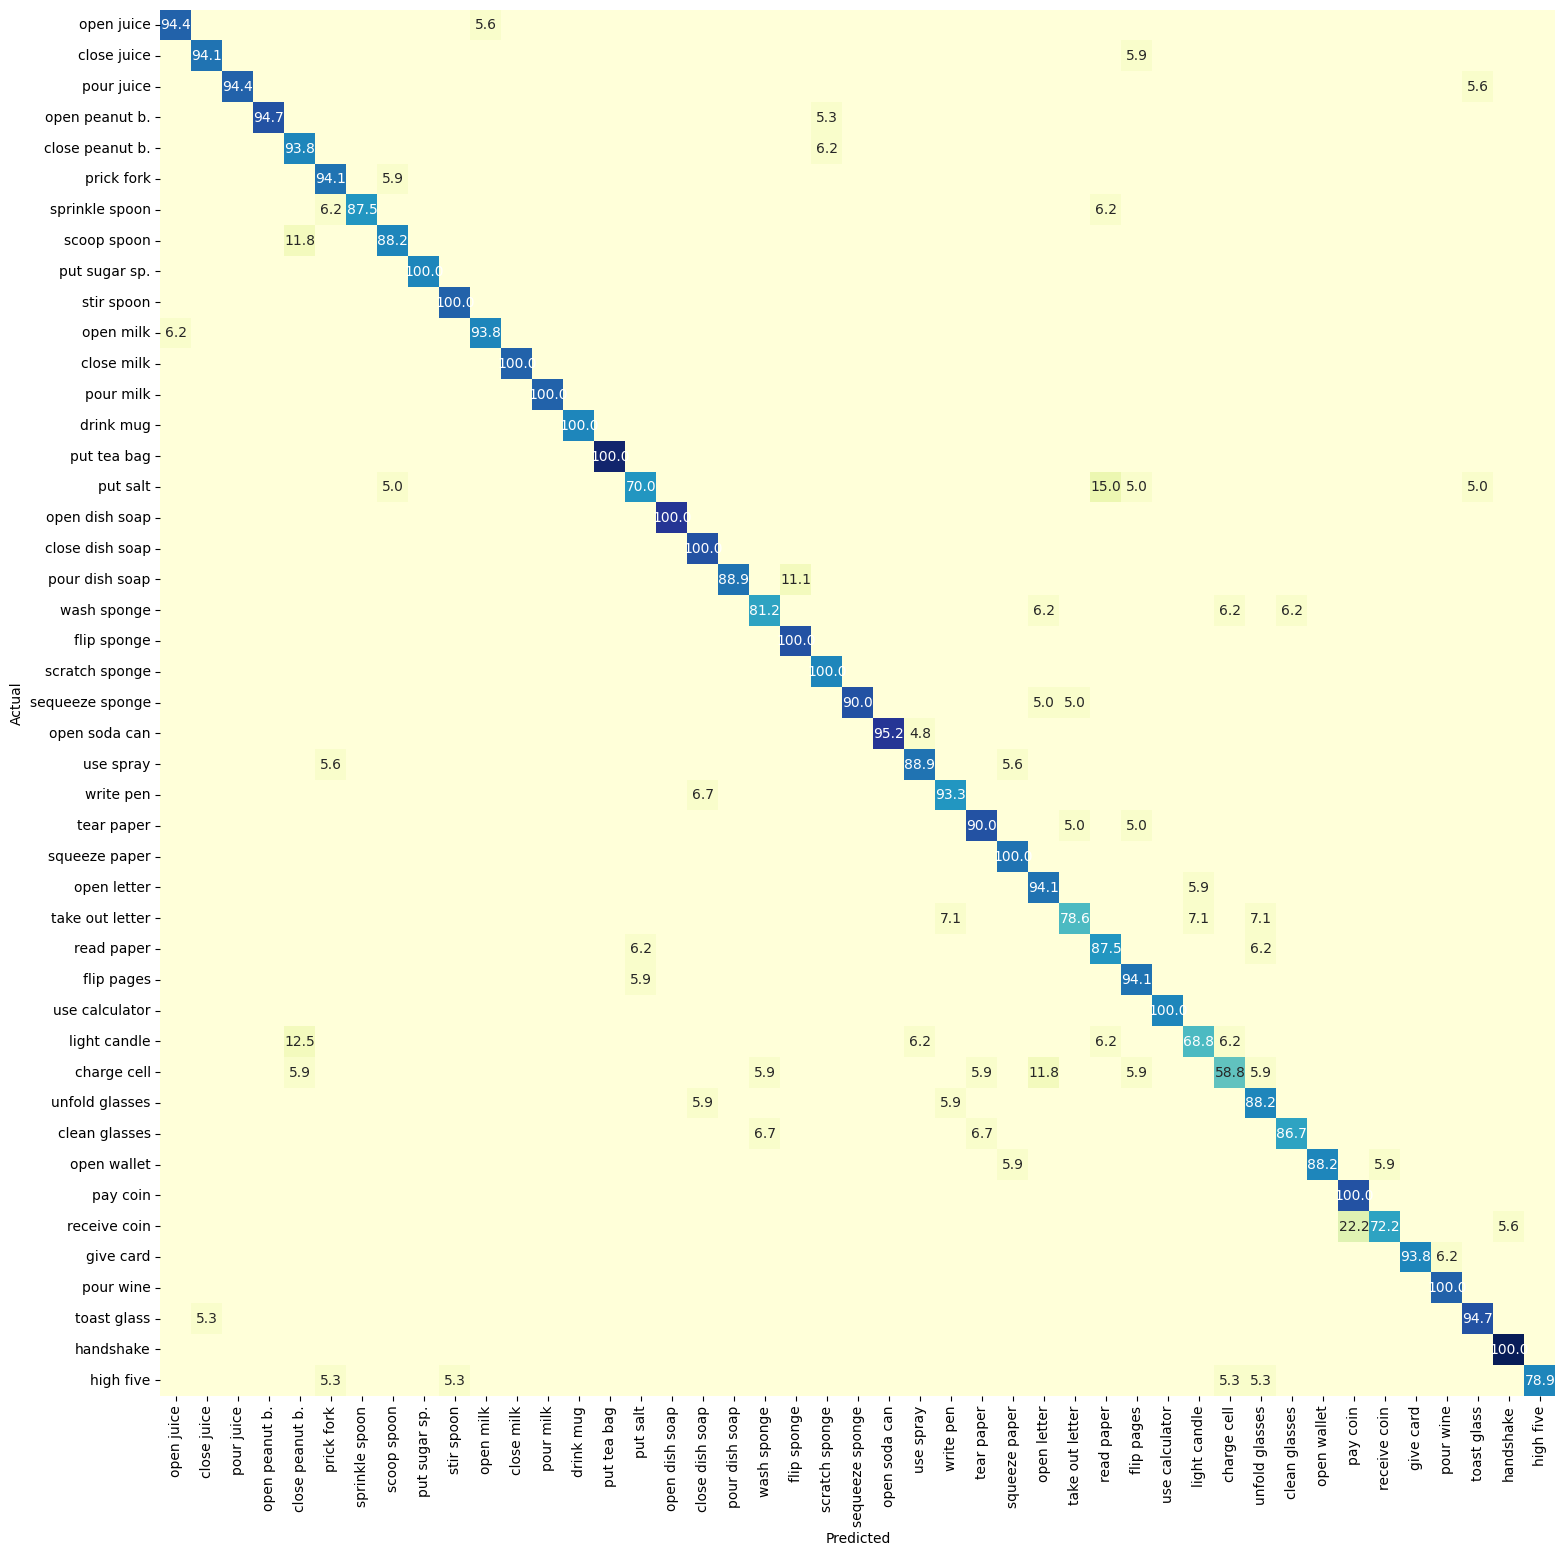

In [34]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_130_test5.png', labels, ymap=None, figsize=(18,18))

### epoch 2 

In [35]:
all_rewards,x_trnew_2,policy_net=train(x_trnew,labels_original)

 49%|████████████████████                     | 192/392 [02:11<02:15,  1.47it/s]


 98%|████████████████████████████████████████▎| 386/392 [04:20<00:04,  1.48it/s]


100%|████████████████████████████████████████████| 1/1 [04:24<00:00, 264.49s/it]


[-12.25]


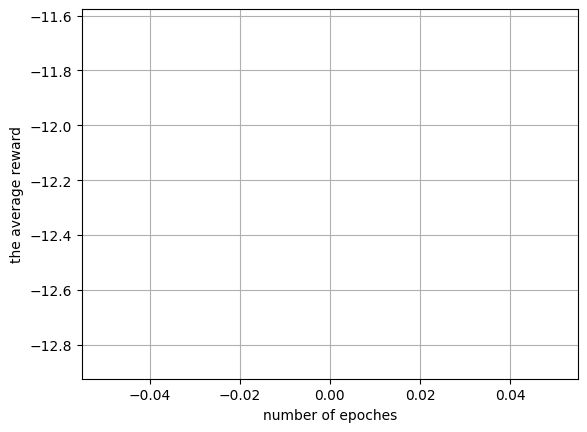

In [36]:
print(all_rewards)
plt.plot(all_rewards)
#plt.xlabel('number of epoches')
#plt.ylabel('the average reward')
#plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLNNet_130_test6_reward.png")
#plt.grid()

In [37]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew_2))):
    w_p = np.copy(x_trnew_2[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|████████████████████████████████████████| 392/392 [00:03<00:00, 128.85it/s]


In [38]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl, 
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 392 samples, validate on 783 samples
Epoch 1/600
392/392 [==============================] - 4s 10ms/step - loss: 0.1065 - accuracy: 0.9923 - val_loss: 0.4442 - val_accuracy: 0.8748
Epoch 2/600
392/392 [==============================] - 0s 237us/step - loss: 0.1609 - accuracy: 0.9694 - val_loss: 0.4265 - val_accuracy: 0.8914
Epoch 3/600
392/392 [==============================] - 0s 234us/step - loss: 0.1218 - accuracy: 0.9847 - val_loss: 0.5295 - val_accuracy: 0.8608
Epoch 4/600
392/392 [==============================] - 0s 227us/step - loss: 0.1398 - accuracy: 0.9898 - val_loss: 0.6678 - val_accuracy: 0.8263
Epoch 5/600
392/392 [==============================] - 0s 224us/step - loss: 0.1443 - accuracy: 0.9770 - val_loss: 0.8420 - val_accuracy: 0.7867
Epoch 6/600
392/392 [==============================] - 0s 214us/step - loss: 0.1832 - accuracy: 0.9719 - val_loss: 0.8606 - val_accuracy: 0.7739
Epoch 7/600
392/392 [==============================] - 0s 234us/step - loss: 0.1444 -

Epoch 57/600
392/392 [==============================] - 0s 261us/step - loss: 0.0749 - accuracy: 0.9949 - val_loss: 0.3530 - val_accuracy: 0.9055
Epoch 58/600
392/392 [==============================] - 0s 281us/step - loss: 0.0577 - accuracy: 1.0000 - val_loss: 0.3512 - val_accuracy: 0.9068
Epoch 59/600
392/392 [==============================] - 0s 271us/step - loss: 0.0746 - accuracy: 0.9974 - val_loss: 0.3492 - val_accuracy: 0.9068
Epoch 60/600
392/392 [==============================] - 0s 252us/step - loss: 0.0731 - accuracy: 0.9898 - val_loss: 0.3478 - val_accuracy: 0.9068
Epoch 61/600
392/392 [==============================] - 0s 263us/step - loss: 0.0826 - accuracy: 0.9949 - val_loss: 0.3464 - val_accuracy: 0.9055
Epoch 62/600
392/392 [==============================] - 0s 249us/step - loss: 0.0793 - accuracy: 1.0000 - val_loss: 0.3447 - val_accuracy: 0.9068
Epoch 63/600
392/392 [==============================] - 0s 288us/step - loss: 0.0846 - accuracy: 0.9974 - val_loss: 0.3428 -

392/392 [==============================] - 0s 257us/step - loss: 0.0965 - accuracy: 0.9949 - val_loss: 0.3063 - val_accuracy: 0.9132
Epoch 114/600
392/392 [==============================] - 0s 250us/step - loss: 0.0757 - accuracy: 0.9923 - val_loss: 0.3058 - val_accuracy: 0.9132
Epoch 115/600
392/392 [==============================] - 0s 255us/step - loss: 0.0686 - accuracy: 0.9974 - val_loss: 0.3054 - val_accuracy: 0.9132
Epoch 116/600
392/392 [==============================] - 0s 243us/step - loss: 0.0716 - accuracy: 1.0000 - val_loss: 0.3050 - val_accuracy: 0.9132
Epoch 117/600
392/392 [==============================] - 0s 246us/step - loss: 0.0955 - accuracy: 0.9949 - val_loss: 0.3046 - val_accuracy: 0.9132
Epoch 118/600
392/392 [==============================] - 0s 245us/step - loss: 0.1003 - accuracy: 0.9898 - val_loss: 0.3043 - val_accuracy: 0.9132
Epoch 119/600
392/392 [==============================] - 0s 256us/step - loss: 0.0674 - accuracy: 1.0000 - val_loss: 0.3039 - val_ac

Epoch 169/600
392/392 [==============================] - 0s 247us/step - loss: 0.0551 - accuracy: 1.0000 - val_loss: 0.2929 - val_accuracy: 0.9195
Epoch 170/600
392/392 [==============================] - 0s 249us/step - loss: 0.0747 - accuracy: 0.9898 - val_loss: 0.2928 - val_accuracy: 0.9195
Epoch 171/600
392/392 [==============================] - 0s 259us/step - loss: 0.0726 - accuracy: 0.9923 - val_loss: 0.2927 - val_accuracy: 0.9195
Epoch 172/600
392/392 [==============================] - 0s 257us/step - loss: 0.0724 - accuracy: 0.9974 - val_loss: 0.2925 - val_accuracy: 0.9195
Epoch 173/600
392/392 [==============================] - 0s 260us/step - loss: 0.0699 - accuracy: 0.9974 - val_loss: 0.2924 - val_accuracy: 0.9195
Epoch 174/600
392/392 [==============================] - 0s 254us/step - loss: 0.0666 - accuracy: 0.9949 - val_loss: 0.2923 - val_accuracy: 0.9195
Epoch 175/600
392/392 [==============================] - 0s 268us/step - loss: 0.0730 - accuracy: 0.9974 - val_loss: 0

Epoch 225/600
392/392 [==============================] - 0s 259us/step - loss: 0.0638 - accuracy: 0.9949 - val_loss: 0.2880 - val_accuracy: 0.9234
Epoch 226/600
392/392 [==============================] - 0s 247us/step - loss: 0.0742 - accuracy: 0.9923 - val_loss: 0.2879 - val_accuracy: 0.9234
Epoch 227/600
392/392 [==============================] - 0s 252us/step - loss: 0.0970 - accuracy: 0.9847 - val_loss: 0.2879 - val_accuracy: 0.9234
Epoch 228/600
392/392 [==============================] - 0s 240us/step - loss: 0.0542 - accuracy: 1.0000 - val_loss: 0.2878 - val_accuracy: 0.9234
Epoch 229/600
392/392 [==============================] - 0s 253us/step - loss: 0.0675 - accuracy: 0.9949 - val_loss: 0.2878 - val_accuracy: 0.9234
Epoch 230/600
392/392 [==============================] - 0s 256us/step - loss: 0.0643 - accuracy: 1.0000 - val_loss: 0.2878 - val_accuracy: 0.9234
Epoch 231/600
392/392 [==============================] - 0s 250us/step - loss: 0.0775 - accuracy: 0.9923 - val_loss: 0

Epoch 281/600
392/392 [==============================] - 0s 250us/step - loss: 0.0727 - accuracy: 0.9974 - val_loss: 0.2855 - val_accuracy: 0.9259
Epoch 282/600
392/392 [==============================] - 0s 233us/step - loss: 0.0675 - accuracy: 0.9898 - val_loss: 0.2854 - val_accuracy: 0.9259
Epoch 283/600
392/392 [==============================] - 0s 248us/step - loss: 0.0697 - accuracy: 1.0000 - val_loss: 0.2854 - val_accuracy: 0.9272
Epoch 284/600
392/392 [==============================] - 0s 236us/step - loss: 0.0605 - accuracy: 0.9949 - val_loss: 0.2853 - val_accuracy: 0.9272
Epoch 285/600
392/392 [==============================] - 0s 257us/step - loss: 0.0602 - accuracy: 1.0000 - val_loss: 0.2853 - val_accuracy: 0.9272
Epoch 286/600
392/392 [==============================] - 0s 249us/step - loss: 0.0613 - accuracy: 1.0000 - val_loss: 0.2853 - val_accuracy: 0.9272
Epoch 287/600
392/392 [==============================] - 0s 247us/step - loss: 0.0863 - accuracy: 0.9872 - val_loss: 0

Epoch 337/600
392/392 [==============================] - 0s 253us/step - loss: 0.0696 - accuracy: 0.9949 - val_loss: 0.2847 - val_accuracy: 0.9234
Epoch 338/600
392/392 [==============================] - 0s 244us/step - loss: 0.0557 - accuracy: 1.0000 - val_loss: 0.2846 - val_accuracy: 0.9234
Epoch 339/600
392/392 [==============================] - 0s 259us/step - loss: 0.0568 - accuracy: 0.9974 - val_loss: 0.2846 - val_accuracy: 0.9234
Epoch 340/600
392/392 [==============================] - 0s 250us/step - loss: 0.0717 - accuracy: 0.9949 - val_loss: 0.2846 - val_accuracy: 0.9234
Epoch 341/600
392/392 [==============================] - 0s 247us/step - loss: 0.0781 - accuracy: 0.9974 - val_loss: 0.2846 - val_accuracy: 0.9234
Epoch 342/600
392/392 [==============================] - 0s 246us/step - loss: 0.0681 - accuracy: 1.0000 - val_loss: 0.2846 - val_accuracy: 0.9234
Epoch 343/600
392/392 [==============================] - 0s 262us/step - loss: 0.0598 - accuracy: 0.9974 - val_loss: 0

Epoch 393/600
392/392 [==============================] - 0s 252us/step - loss: 0.0642 - accuracy: 0.9923 - val_loss: 0.2844 - val_accuracy: 0.9272
Epoch 394/600
392/392 [==============================] - 0s 262us/step - loss: 0.0630 - accuracy: 0.9923 - val_loss: 0.2844 - val_accuracy: 0.9272
Epoch 395/600
392/392 [==============================] - 0s 275us/step - loss: 0.0795 - accuracy: 0.9923 - val_loss: 0.2844 - val_accuracy: 0.9272
Epoch 396/600
392/392 [==============================] - 0s 258us/step - loss: 0.0703 - accuracy: 0.9974 - val_loss: 0.2844 - val_accuracy: 0.9259
Epoch 397/600
392/392 [==============================] - 0s 281us/step - loss: 0.0701 - accuracy: 0.9949 - val_loss: 0.2844 - val_accuracy: 0.9259
Epoch 398/600
392/392 [==============================] - 0s 273us/step - loss: 0.0711 - accuracy: 0.9949 - val_loss: 0.2844 - val_accuracy: 0.9259
Epoch 399/600
392/392 [==============================] - 0s 249us/step - loss: 0.0752 - accuracy: 0.9974 - val_loss: 0

Epoch 449/600
392/392 [==============================] - 0s 230us/step - loss: 0.0643 - accuracy: 0.9949 - val_loss: 0.2834 - val_accuracy: 0.9272
Epoch 450/600
392/392 [==============================] - 0s 233us/step - loss: 0.0656 - accuracy: 0.9974 - val_loss: 0.2834 - val_accuracy: 0.9272
Epoch 451/600
392/392 [==============================] - 0s 237us/step - loss: 0.0706 - accuracy: 0.9974 - val_loss: 0.2835 - val_accuracy: 0.9272
Epoch 452/600
392/392 [==============================] - 0s 236us/step - loss: 0.0681 - accuracy: 0.9949 - val_loss: 0.2834 - val_accuracy: 0.9272
Epoch 453/600
392/392 [==============================] - 0s 243us/step - loss: 0.0707 - accuracy: 0.9949 - val_loss: 0.2834 - val_accuracy: 0.9272
Epoch 454/600
392/392 [==============================] - 0s 232us/step - loss: 0.0672 - accuracy: 0.9974 - val_loss: 0.2835 - val_accuracy: 0.9272
Epoch 455/600
392/392 [==============================] - 0s 237us/step - loss: 0.0710 - accuracy: 1.0000 - val_loss: 0

Epoch 505/600
392/392 [==============================] - 0s 248us/step - loss: 0.0593 - accuracy: 1.0000 - val_loss: 0.2830 - val_accuracy: 0.9272
Epoch 506/600
392/392 [==============================] - 0s 255us/step - loss: 0.0678 - accuracy: 0.9974 - val_loss: 0.2830 - val_accuracy: 0.9272
Epoch 507/600
392/392 [==============================] - 0s 252us/step - loss: 0.0618 - accuracy: 1.0000 - val_loss: 0.2830 - val_accuracy: 0.9272
Epoch 508/600
392/392 [==============================] - 0s 250us/step - loss: 0.0669 - accuracy: 1.0000 - val_loss: 0.2830 - val_accuracy: 0.9272
Epoch 509/600
392/392 [==============================] - 0s 259us/step - loss: 0.0569 - accuracy: 0.9949 - val_loss: 0.2830 - val_accuracy: 0.9272
Epoch 510/600
392/392 [==============================] - 0s 252us/step - loss: 0.0778 - accuracy: 0.9949 - val_loss: 0.2830 - val_accuracy: 0.9272
Epoch 511/600
392/392 [==============================] - 0s 275us/step - loss: 0.0738 - accuracy: 0.9974 - val_loss: 0

Epoch 561/600
392/392 [==============================] - 0s 286us/step - loss: 0.0682 - accuracy: 0.9974 - val_loss: 0.2813 - val_accuracy: 0.9272
Epoch 562/600
392/392 [==============================] - 0s 242us/step - loss: 0.0598 - accuracy: 0.9974 - val_loss: 0.2813 - val_accuracy: 0.9272
Epoch 563/600
392/392 [==============================] - 0s 265us/step - loss: 0.0565 - accuracy: 1.0000 - val_loss: 0.2813 - val_accuracy: 0.9272
Epoch 564/600
392/392 [==============================] - 0s 228us/step - loss: 0.0658 - accuracy: 0.9974 - val_loss: 0.2813 - val_accuracy: 0.9272
Epoch 565/600
392/392 [==============================] - 0s 261us/step - loss: 0.0715 - accuracy: 1.0000 - val_loss: 0.2813 - val_accuracy: 0.9272
Epoch 566/600
392/392 [==============================] - 0s 252us/step - loss: 0.0756 - accuracy: 1.0000 - val_loss: 0.2813 - val_accuracy: 0.9272
Epoch 567/600
392/392 [==============================] - 0s 253us/step - loss: 0.0465 - accuracy: 1.0000 - val_loss: 0

In [39]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9284802043422733


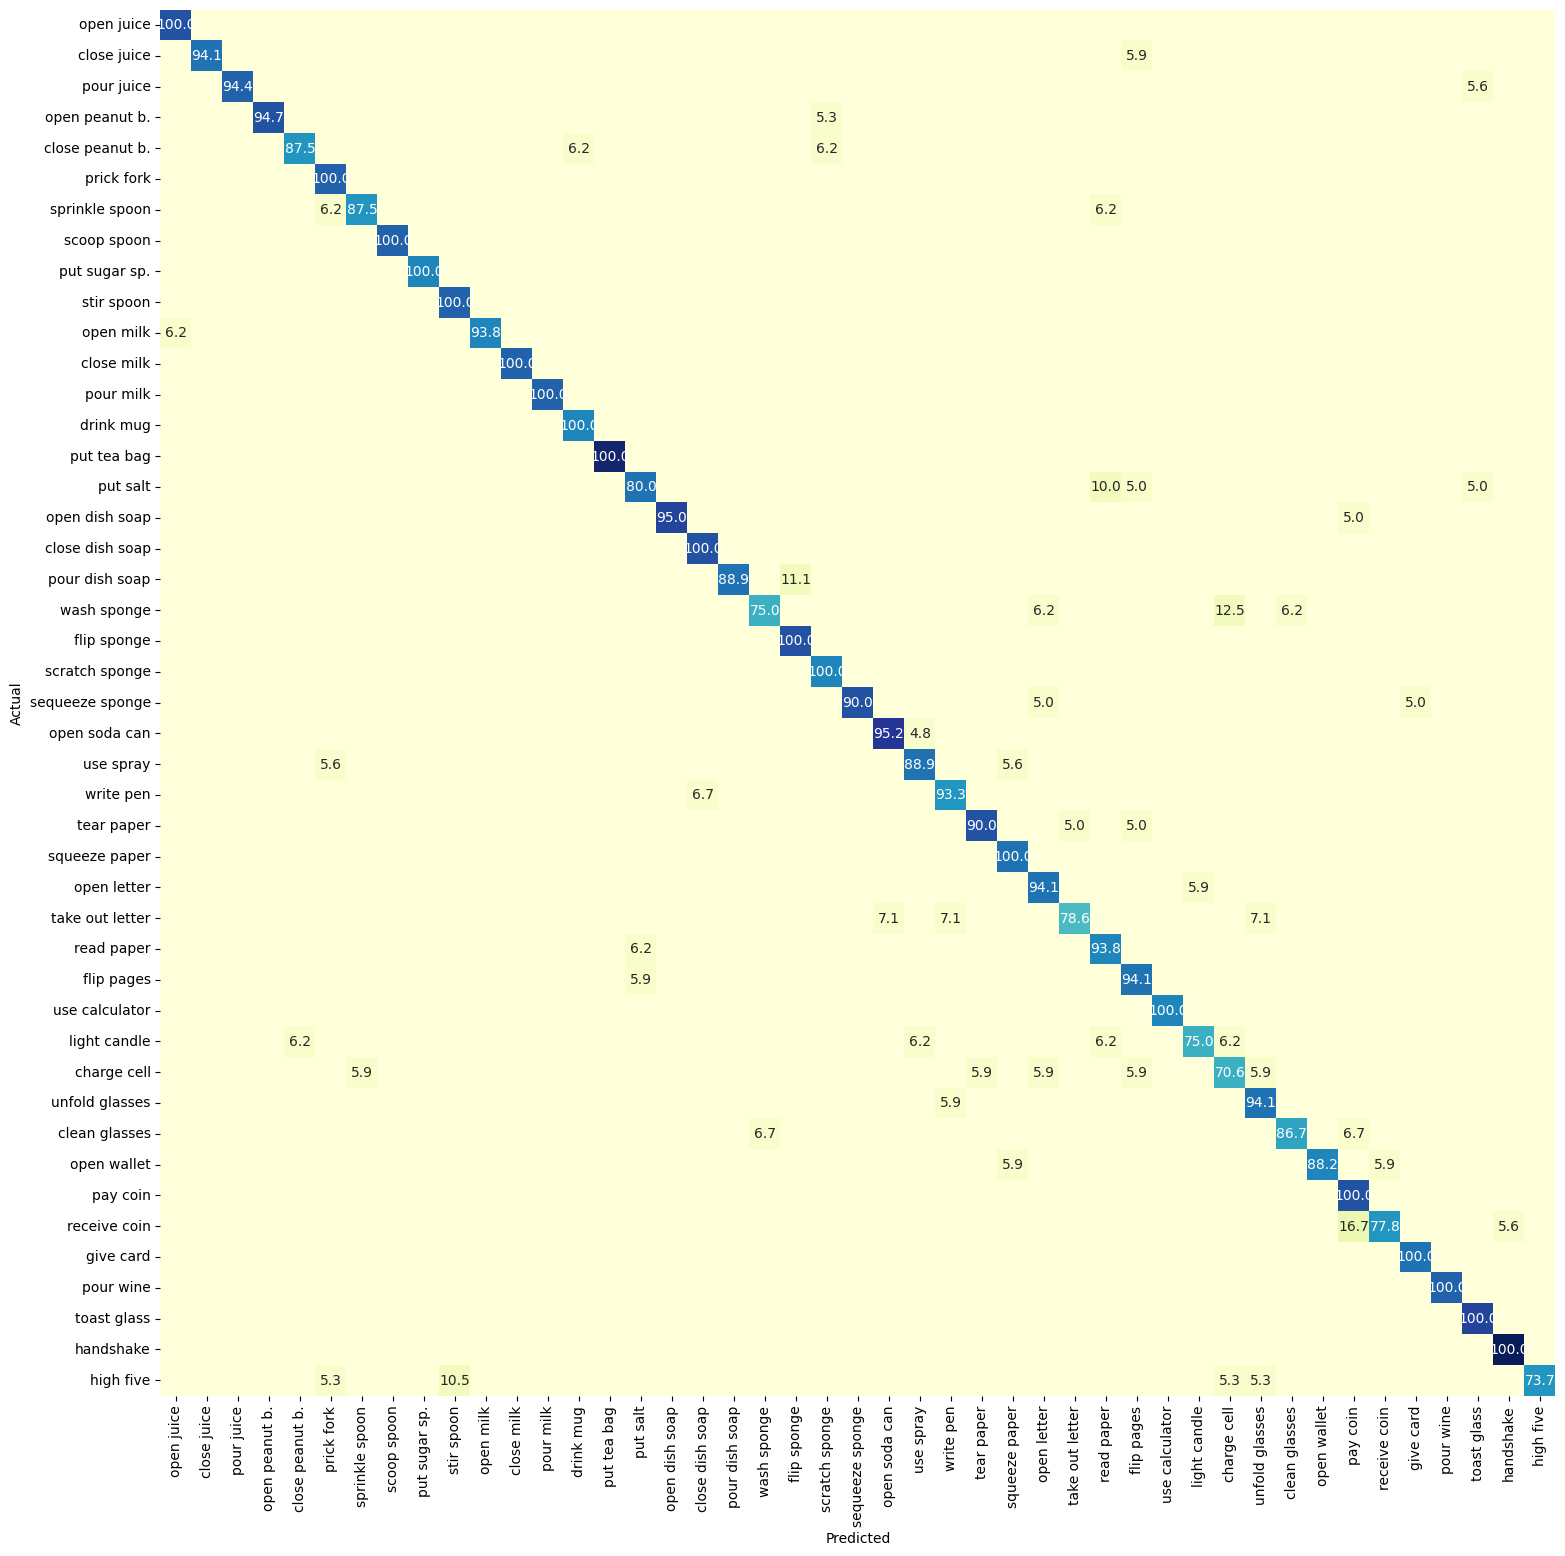

In [40]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_130_test6.png', labels, ymap=None, figsize=(18,18))

### epoch 3 

In [41]:
all_rewards,x_trnew_3,policy_net=train(x_trnew_2,labels_original)
print(all_rewards)
X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_3))):
    w_p = np.copy(x_trnew_3[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

 49%|████████████████████                     | 192/392 [02:12<02:20,  1.43it/s]


 98%|████████████████████████████████████████▎| 386/392 [04:28<00:04,  1.48it/s]


100%|████████████████████████████████████████████| 1/1 [04:32<00:00, 272.21s/it]


[-12.25]


100%|████████████████████████████████████████| 392/392 [00:02<00:00, 136.76it/s]


In [42]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl, 
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 392 samples, validate on 783 samples
Epoch 1/600
392/392 [==============================] - 4s 10ms/step - loss: 0.0668 - accuracy: 0.9974 - val_loss: 0.4433 - val_accuracy: 0.8799
Epoch 2/600
392/392 [==============================] - 0s 232us/step - loss: 0.0803 - accuracy: 0.9949 - val_loss: 0.4616 - val_accuracy: 0.8889
Epoch 3/600
392/392 [==============================] - 0s 244us/step - loss: 0.0917 - accuracy: 0.9898 - val_loss: 0.5955 - val_accuracy: 0.8557
Epoch 4/600
392/392 [==============================] - 0s 228us/step - loss: 0.0977 - accuracy: 0.9872 - val_loss: 0.7184 - val_accuracy: 0.8314
Epoch 5/600
392/392 [==============================] - 0s 226us/step - loss: 0.0940 - accuracy: 0.9872 - val_loss: 0.8141 - val_accuracy: 0.8110
Epoch 6/600
392/392 [==============================] - 0s 221us/step - loss: 0.1142 - accuracy: 0.9872 - val_loss: 0.8761 - val_accuracy: 0.7982
Epoch 7/600
392/392 [==============================] - 0s 216us/step - loss: 0.0987 -

Epoch 57/600
392/392 [==============================] - 0s 254us/step - loss: 0.0617 - accuracy: 0.9974 - val_loss: 0.3022 - val_accuracy: 0.9144
Epoch 58/600
392/392 [==============================] - 0s 249us/step - loss: 0.0462 - accuracy: 0.9949 - val_loss: 0.3020 - val_accuracy: 0.9144
Epoch 59/600
392/392 [==============================] - 0s 258us/step - loss: 0.0493 - accuracy: 0.9974 - val_loss: 0.3017 - val_accuracy: 0.9132
Epoch 60/600
392/392 [==============================] - 0s 246us/step - loss: 0.0518 - accuracy: 0.9974 - val_loss: 0.3013 - val_accuracy: 0.9132
Epoch 61/600
392/392 [==============================] - 0s 259us/step - loss: 0.0578 - accuracy: 1.0000 - val_loss: 0.3008 - val_accuracy: 0.9132
Epoch 62/600
392/392 [==============================] - 0s 275us/step - loss: 0.0501 - accuracy: 0.9949 - val_loss: 0.3003 - val_accuracy: 0.9132
Epoch 63/600
392/392 [==============================] - 0s 254us/step - loss: 0.0591 - accuracy: 0.9923 - val_loss: 0.2999 -

392/392 [==============================] - 0s 246us/step - loss: 0.0505 - accuracy: 1.0000 - val_loss: 0.2927 - val_accuracy: 0.9195
Epoch 114/600
392/392 [==============================] - 0s 250us/step - loss: 0.0561 - accuracy: 1.0000 - val_loss: 0.2926 - val_accuracy: 0.9195
Epoch 115/600
392/392 [==============================] - 0s 240us/step - loss: 0.0565 - accuracy: 0.9974 - val_loss: 0.2926 - val_accuracy: 0.9195
Epoch 116/600
392/392 [==============================] - 0s 237us/step - loss: 0.0455 - accuracy: 0.9949 - val_loss: 0.2925 - val_accuracy: 0.9195
Epoch 117/600
392/392 [==============================] - 0s 262us/step - loss: 0.0540 - accuracy: 0.9949 - val_loss: 0.2925 - val_accuracy: 0.9195
Epoch 118/600
392/392 [==============================] - 0s 244us/step - loss: 0.0577 - accuracy: 0.9949 - val_loss: 0.2924 - val_accuracy: 0.9195
Epoch 119/600
392/392 [==============================] - 0s 243us/step - loss: 0.0628 - accuracy: 0.9923 - val_loss: 0.2923 - val_ac

Epoch 169/600
392/392 [==============================] - 0s 249us/step - loss: 0.0351 - accuracy: 1.0000 - val_loss: 0.2888 - val_accuracy: 0.9183
Epoch 170/600
392/392 [==============================] - 0s 239us/step - loss: 0.0511 - accuracy: 0.9923 - val_loss: 0.2888 - val_accuracy: 0.9183
Epoch 171/600
392/392 [==============================] - 0s 238us/step - loss: 0.0526 - accuracy: 0.9949 - val_loss: 0.2888 - val_accuracy: 0.9183
Epoch 172/600
392/392 [==============================] - 0s 247us/step - loss: 0.0480 - accuracy: 0.9974 - val_loss: 0.2888 - val_accuracy: 0.9195
Epoch 173/600
392/392 [==============================] - 0s 245us/step - loss: 0.0531 - accuracy: 0.9949 - val_loss: 0.2888 - val_accuracy: 0.9195
Epoch 174/600
392/392 [==============================] - 0s 241us/step - loss: 0.0429 - accuracy: 1.0000 - val_loss: 0.2889 - val_accuracy: 0.9195
Epoch 175/600
392/392 [==============================] - 0s 249us/step - loss: 0.0438 - accuracy: 1.0000 - val_loss: 0

Epoch 225/600
392/392 [==============================] - 0s 252us/step - loss: 0.0564 - accuracy: 0.9974 - val_loss: 0.2879 - val_accuracy: 0.9195
Epoch 226/600
392/392 [==============================] - 0s 236us/step - loss: 0.0503 - accuracy: 0.9923 - val_loss: 0.2878 - val_accuracy: 0.9195
Epoch 227/600
392/392 [==============================] - 0s 249us/step - loss: 0.0674 - accuracy: 0.9949 - val_loss: 0.2878 - val_accuracy: 0.9195
Epoch 228/600
392/392 [==============================] - 0s 238us/step - loss: 0.0487 - accuracy: 0.9949 - val_loss: 0.2877 - val_accuracy: 0.9195
Epoch 229/600
392/392 [==============================] - 0s 247us/step - loss: 0.0428 - accuracy: 1.0000 - val_loss: 0.2876 - val_accuracy: 0.9195
Epoch 230/600
392/392 [==============================] - 0s 242us/step - loss: 0.0489 - accuracy: 0.9949 - val_loss: 0.2876 - val_accuracy: 0.9195
Epoch 231/600
392/392 [==============================] - 0s 259us/step - loss: 0.0477 - accuracy: 0.9949 - val_loss: 0

Epoch 281/600
392/392 [==============================] - 0s 237us/step - loss: 0.0398 - accuracy: 1.0000 - val_loss: 0.2879 - val_accuracy: 0.9195
Epoch 282/600
392/392 [==============================] - 0s 245us/step - loss: 0.0540 - accuracy: 0.9974 - val_loss: 0.2879 - val_accuracy: 0.9195
Epoch 283/600
392/392 [==============================] - 0s 230us/step - loss: 0.0440 - accuracy: 0.9949 - val_loss: 0.2879 - val_accuracy: 0.9195
Epoch 284/600
392/392 [==============================] - 0s 246us/step - loss: 0.0436 - accuracy: 0.9974 - val_loss: 0.2879 - val_accuracy: 0.9195
Epoch 285/600
392/392 [==============================] - 0s 285us/step - loss: 0.0393 - accuracy: 1.0000 - val_loss: 0.2879 - val_accuracy: 0.9195
Epoch 286/600
392/392 [==============================] - 0s 241us/step - loss: 0.0542 - accuracy: 0.9974 - val_loss: 0.2879 - val_accuracy: 0.9195
Epoch 287/600
392/392 [==============================] - 0s 247us/step - loss: 0.0505 - accuracy: 0.9974 - val_loss: 0

Epoch 337/600
392/392 [==============================] - 0s 234us/step - loss: 0.0433 - accuracy: 0.9974 - val_loss: 0.2875 - val_accuracy: 0.9170
Epoch 338/600
392/392 [==============================] - 0s 238us/step - loss: 0.0482 - accuracy: 0.9949 - val_loss: 0.2874 - val_accuracy: 0.9170
Epoch 339/600
392/392 [==============================] - 0s 246us/step - loss: 0.0457 - accuracy: 1.0000 - val_loss: 0.2874 - val_accuracy: 0.9170
Epoch 340/600
392/392 [==============================] - 0s 258us/step - loss: 0.0425 - accuracy: 0.9974 - val_loss: 0.2874 - val_accuracy: 0.9170
Epoch 341/600
392/392 [==============================] - 0s 242us/step - loss: 0.0520 - accuracy: 0.9949 - val_loss: 0.2874 - val_accuracy: 0.9170
Epoch 342/600
392/392 [==============================] - 0s 235us/step - loss: 0.0551 - accuracy: 0.9974 - val_loss: 0.2874 - val_accuracy: 0.9170
Epoch 343/600
392/392 [==============================] - 0s 233us/step - loss: 0.0420 - accuracy: 1.0000 - val_loss: 0

Epoch 393/600
392/392 [==============================] - 0s 243us/step - loss: 0.0443 - accuracy: 1.0000 - val_loss: 0.2858 - val_accuracy: 0.9195
Epoch 394/600
392/392 [==============================] - 0s 235us/step - loss: 0.0524 - accuracy: 0.9949 - val_loss: 0.2858 - val_accuracy: 0.9208
Epoch 395/600
392/392 [==============================] - 0s 255us/step - loss: 0.0459 - accuracy: 0.9974 - val_loss: 0.2858 - val_accuracy: 0.9208
Epoch 396/600
392/392 [==============================] - 0s 252us/step - loss: 0.0471 - accuracy: 1.0000 - val_loss: 0.2858 - val_accuracy: 0.9208
Epoch 397/600
392/392 [==============================] - 0s 242us/step - loss: 0.0447 - accuracy: 0.9974 - val_loss: 0.2858 - val_accuracy: 0.9208
Epoch 398/600
392/392 [==============================] - 0s 244us/step - loss: 0.0625 - accuracy: 0.9949 - val_loss: 0.2858 - val_accuracy: 0.9208
Epoch 399/600
392/392 [==============================] - 0s 246us/step - loss: 0.0469 - accuracy: 0.9949 - val_loss: 0

Epoch 449/600
392/392 [==============================] - 0s 236us/step - loss: 0.0596 - accuracy: 0.9949 - val_loss: 0.2851 - val_accuracy: 0.9183
Epoch 450/600
392/392 [==============================] - 0s 232us/step - loss: 0.0576 - accuracy: 0.9949 - val_loss: 0.2851 - val_accuracy: 0.9183
Epoch 451/600
392/392 [==============================] - 0s 229us/step - loss: 0.0436 - accuracy: 0.9949 - val_loss: 0.2851 - val_accuracy: 0.9183
Epoch 452/600
392/392 [==============================] - 0s 235us/step - loss: 0.0375 - accuracy: 0.9974 - val_loss: 0.2851 - val_accuracy: 0.9183
Epoch 453/600
392/392 [==============================] - 0s 252us/step - loss: 0.0521 - accuracy: 0.9974 - val_loss: 0.2851 - val_accuracy: 0.9183
Epoch 454/600
392/392 [==============================] - 0s 236us/step - loss: 0.0473 - accuracy: 0.9974 - val_loss: 0.2852 - val_accuracy: 0.9183
Epoch 455/600
392/392 [==============================] - 0s 247us/step - loss: 0.0518 - accuracy: 0.9949 - val_loss: 0

Epoch 505/600
392/392 [==============================] - 0s 238us/step - loss: 0.0527 - accuracy: 1.0000 - val_loss: 0.2855 - val_accuracy: 0.9183
Epoch 506/600
392/392 [==============================] - 0s 234us/step - loss: 0.0350 - accuracy: 1.0000 - val_loss: 0.2855 - val_accuracy: 0.9183
Epoch 507/600
392/392 [==============================] - 0s 243us/step - loss: 0.0529 - accuracy: 1.0000 - val_loss: 0.2855 - val_accuracy: 0.9183
Epoch 508/600
392/392 [==============================] - 0s 235us/step - loss: 0.0495 - accuracy: 0.9974 - val_loss: 0.2855 - val_accuracy: 0.9183
Epoch 509/600
392/392 [==============================] - 0s 244us/step - loss: 0.0416 - accuracy: 0.9974 - val_loss: 0.2855 - val_accuracy: 0.9183
Epoch 510/600
392/392 [==============================] - 0s 249us/step - loss: 0.0492 - accuracy: 0.9923 - val_loss: 0.2855 - val_accuracy: 0.9183
Epoch 511/600
392/392 [==============================] - 0s 232us/step - loss: 0.0400 - accuracy: 1.0000 - val_loss: 0

Epoch 561/600
392/392 [==============================] - 0s 249us/step - loss: 0.0391 - accuracy: 1.0000 - val_loss: 0.2846 - val_accuracy: 0.9183
Epoch 562/600
392/392 [==============================] - 0s 241us/step - loss: 0.0525 - accuracy: 0.9974 - val_loss: 0.2846 - val_accuracy: 0.9183
Epoch 563/600
392/392 [==============================] - 0s 255us/step - loss: 0.0457 - accuracy: 1.0000 - val_loss: 0.2846 - val_accuracy: 0.9183
Epoch 564/600
392/392 [==============================] - 0s 245us/step - loss: 0.0462 - accuracy: 0.9974 - val_loss: 0.2846 - val_accuracy: 0.9183
Epoch 565/600
392/392 [==============================] - 0s 239us/step - loss: 0.0576 - accuracy: 0.9974 - val_loss: 0.2847 - val_accuracy: 0.9183
Epoch 566/600
392/392 [==============================] - 0s 242us/step - loss: 0.0433 - accuracy: 0.9949 - val_loss: 0.2847 - val_accuracy: 0.9183
Epoch 567/600
392/392 [==============================] - 0s 247us/step - loss: 0.0436 - accuracy: 1.0000 - val_loss: 0

In [43]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9182630906768838


### epoch 4

In [44]:
all_rewards,x_trnew_4,policy_net=train(x_trnew_3,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_4))):
    w_p = np.copy(x_trnew_4[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

 49%|████████████████████                     | 192/392 [02:11<02:12,  1.51it/s]


 98%|████████████████████████████████████████▎| 386/392 [04:27<00:04,  1.41it/s]


100%|████████████████████████████████████████████| 1/1 [04:31<00:00, 271.48s/it]


[-12.25]


100%|████████████████████████████████████████| 392/392 [00:03<00:00, 120.55it/s]


In [45]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl, 
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 392 samples, validate on 783 samples
Epoch 1/600
392/392 [==============================] - 4s 10ms/step - loss: 0.0443 - accuracy: 0.9923 - val_loss: 0.4402 - val_accuracy: 0.8863
Epoch 2/600
392/392 [==============================] - 0s 233us/step - loss: 0.0531 - accuracy: 1.0000 - val_loss: 0.5200 - val_accuracy: 0.8736
Epoch 3/600
392/392 [==============================] - 0s 223us/step - loss: 0.0718 - accuracy: 0.9923 - val_loss: 0.5280 - val_accuracy: 0.8659
Epoch 4/600
392/392 [==============================] - 0s 227us/step - loss: 0.0584 - accuracy: 0.9974 - val_loss: 0.6466 - val_accuracy: 0.8391
Epoch 5/600
392/392 [==============================] - 0s 268us/step - loss: 0.0695 - accuracy: 0.9923 - val_loss: 0.8071 - val_accuracy: 0.8020
Epoch 6/600
392/392 [==============================] - 0s 253us/step - loss: 0.1145 - accuracy: 0.9847 - val_loss: 0.6342 - val_accuracy: 0.8404
Epoch 7/600
392/392 [==============================] - 0s 253us/step - loss: 0.0796 -

Epoch 57/600
392/392 [==============================] - 0s 258us/step - loss: 0.0509 - accuracy: 0.9974 - val_loss: 0.3658 - val_accuracy: 0.9055
Epoch 58/600
392/392 [==============================] - 0s 288us/step - loss: 0.0374 - accuracy: 1.0000 - val_loss: 0.3634 - val_accuracy: 0.9042
Epoch 59/600
392/392 [==============================] - 0s 258us/step - loss: 0.0353 - accuracy: 0.9974 - val_loss: 0.3613 - val_accuracy: 0.9042
Epoch 60/600
392/392 [==============================] - 0s 245us/step - loss: 0.0358 - accuracy: 0.9974 - val_loss: 0.3593 - val_accuracy: 0.9055
Epoch 61/600
392/392 [==============================] - 0s 256us/step - loss: 0.0494 - accuracy: 0.9974 - val_loss: 0.3574 - val_accuracy: 0.9068
Epoch 62/600
392/392 [==============================] - 0s 244us/step - loss: 0.0361 - accuracy: 1.0000 - val_loss: 0.3556 - val_accuracy: 0.9068
Epoch 63/600
392/392 [==============================] - 0s 250us/step - loss: 0.0456 - accuracy: 0.9974 - val_loss: 0.3536 -

392/392 [==============================] - 0s 271us/step - loss: 0.0423 - accuracy: 1.0000 - val_loss: 0.3036 - val_accuracy: 0.9221
Epoch 114/600
392/392 [==============================] - 0s 254us/step - loss: 0.0360 - accuracy: 1.0000 - val_loss: 0.3031 - val_accuracy: 0.9234
Epoch 115/600
392/392 [==============================] - 0s 250us/step - loss: 0.0399 - accuracy: 1.0000 - val_loss: 0.3027 - val_accuracy: 0.9234
Epoch 116/600
392/392 [==============================] - 0s 251us/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 0.3023 - val_accuracy: 0.9234
Epoch 117/600
392/392 [==============================] - 0s 250us/step - loss: 0.0337 - accuracy: 1.0000 - val_loss: 0.3018 - val_accuracy: 0.9221
Epoch 118/600
392/392 [==============================] - 0s 242us/step - loss: 0.0338 - accuracy: 1.0000 - val_loss: 0.3014 - val_accuracy: 0.9221
Epoch 119/600
392/392 [==============================] - 0s 261us/step - loss: 0.0464 - accuracy: 0.9949 - val_loss: 0.3010 - val_ac

Epoch 169/600
392/392 [==============================] - 0s 240us/step - loss: 0.0339 - accuracy: 1.0000 - val_loss: 0.2872 - val_accuracy: 0.9259
Epoch 170/600
392/392 [==============================] - 0s 250us/step - loss: 0.0295 - accuracy: 0.9974 - val_loss: 0.2871 - val_accuracy: 0.9259
Epoch 171/600
392/392 [==============================] - 0s 242us/step - loss: 0.0326 - accuracy: 0.9949 - val_loss: 0.2871 - val_accuracy: 0.9259
Epoch 172/600
392/392 [==============================] - 0s 244us/step - loss: 0.0369 - accuracy: 0.9974 - val_loss: 0.2870 - val_accuracy: 0.9259
Epoch 173/600
392/392 [==============================] - 0s 265us/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 0.2869 - val_accuracy: 0.9246
Epoch 174/600
392/392 [==============================] - 0s 249us/step - loss: 0.0423 - accuracy: 0.9949 - val_loss: 0.2869 - val_accuracy: 0.9246
Epoch 175/600
392/392 [==============================] - 0s 257us/step - loss: 0.0327 - accuracy: 0.9974 - val_loss: 0

Epoch 225/600
392/392 [==============================] - 0s 251us/step - loss: 0.0434 - accuracy: 0.9974 - val_loss: 0.2831 - val_accuracy: 0.9234
Epoch 226/600
392/392 [==============================] - 0s 263us/step - loss: 0.0369 - accuracy: 0.9974 - val_loss: 0.2830 - val_accuracy: 0.9234
Epoch 227/600
392/392 [==============================] - 0s 251us/step - loss: 0.0420 - accuracy: 0.9923 - val_loss: 0.2829 - val_accuracy: 0.9234
Epoch 228/600
392/392 [==============================] - 0s 246us/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 0.2829 - val_accuracy: 0.9234
Epoch 229/600
392/392 [==============================] - 0s 251us/step - loss: 0.0342 - accuracy: 0.9974 - val_loss: 0.2828 - val_accuracy: 0.9234
Epoch 230/600
392/392 [==============================] - 0s 257us/step - loss: 0.0343 - accuracy: 1.0000 - val_loss: 0.2828 - val_accuracy: 0.9234
Epoch 231/600
392/392 [==============================] - 0s 244us/step - loss: 0.0310 - accuracy: 0.9974 - val_loss: 0

Epoch 281/600
392/392 [==============================] - 0s 237us/step - loss: 0.0322 - accuracy: 1.0000 - val_loss: 0.2809 - val_accuracy: 0.9246
Epoch 282/600
392/392 [==============================] - 0s 234us/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.2809 - val_accuracy: 0.9246
Epoch 283/600
392/392 [==============================] - 0s 230us/step - loss: 0.0382 - accuracy: 0.9974 - val_loss: 0.2809 - val_accuracy: 0.9246
Epoch 284/600
392/392 [==============================] - 0s 237us/step - loss: 0.0463 - accuracy: 0.9974 - val_loss: 0.2809 - val_accuracy: 0.9246
Epoch 285/600
392/392 [==============================] - 0s 222us/step - loss: 0.0368 - accuracy: 0.9974 - val_loss: 0.2809 - val_accuracy: 0.9246
Epoch 286/600
392/392 [==============================] - 0s 213us/step - loss: 0.0446 - accuracy: 0.9974 - val_loss: 0.2809 - val_accuracy: 0.9246
Epoch 287/600
392/392 [==============================] - 0s 217us/step - loss: 0.0395 - accuracy: 0.9974 - val_loss: 0

Epoch 337/600
392/392 [==============================] - 0s 262us/step - loss: 0.0408 - accuracy: 1.0000 - val_loss: 0.2791 - val_accuracy: 0.9234
Epoch 338/600
392/392 [==============================] - 0s 248us/step - loss: 0.0416 - accuracy: 1.0000 - val_loss: 0.2791 - val_accuracy: 0.9234
Epoch 339/600
392/392 [==============================] - 0s 238us/step - loss: 0.0341 - accuracy: 1.0000 - val_loss: 0.2791 - val_accuracy: 0.9234
Epoch 340/600
392/392 [==============================] - 0s 243us/step - loss: 0.0338 - accuracy: 1.0000 - val_loss: 0.2791 - val_accuracy: 0.9234
Epoch 341/600
392/392 [==============================] - 0s 249us/step - loss: 0.0424 - accuracy: 0.9974 - val_loss: 0.2790 - val_accuracy: 0.9234
Epoch 342/600
392/392 [==============================] - 0s 254us/step - loss: 0.0336 - accuracy: 1.0000 - val_loss: 0.2790 - val_accuracy: 0.9234
Epoch 343/600
392/392 [==============================] - 0s 278us/step - loss: 0.0431 - accuracy: 0.9923 - val_loss: 0

Epoch 393/600
392/392 [==============================] - 0s 237us/step - loss: 0.0268 - accuracy: 1.0000 - val_loss: 0.2792 - val_accuracy: 0.9259
Epoch 394/600
392/392 [==============================] - 0s 249us/step - loss: 0.0319 - accuracy: 1.0000 - val_loss: 0.2792 - val_accuracy: 0.9259
Epoch 395/600
392/392 [==============================] - 0s 244us/step - loss: 0.0390 - accuracy: 1.0000 - val_loss: 0.2792 - val_accuracy: 0.9259
Epoch 396/600
392/392 [==============================] - 0s 239us/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.2792 - val_accuracy: 0.9259
Epoch 397/600
392/392 [==============================] - 0s 245us/step - loss: 0.0369 - accuracy: 0.9974 - val_loss: 0.2792 - val_accuracy: 0.9259
Epoch 398/600
392/392 [==============================] - 0s 258us/step - loss: 0.0268 - accuracy: 1.0000 - val_loss: 0.2792 - val_accuracy: 0.9259
Epoch 399/600
392/392 [==============================] - 0s 246us/step - loss: 0.0393 - accuracy: 0.9949 - val_loss: 0

Epoch 449/600
392/392 [==============================] - 0s 242us/step - loss: 0.0364 - accuracy: 0.9974 - val_loss: 0.2770 - val_accuracy: 0.9272
Epoch 450/600
392/392 [==============================] - 0s 235us/step - loss: 0.0355 - accuracy: 1.0000 - val_loss: 0.2770 - val_accuracy: 0.9272
Epoch 451/600
392/392 [==============================] - 0s 250us/step - loss: 0.0380 - accuracy: 0.9974 - val_loss: 0.2769 - val_accuracy: 0.9272
Epoch 452/600
392/392 [==============================] - 0s 249us/step - loss: 0.0286 - accuracy: 1.0000 - val_loss: 0.2769 - val_accuracy: 0.9272
Epoch 453/600
392/392 [==============================] - 0s 262us/step - loss: 0.0347 - accuracy: 1.0000 - val_loss: 0.2769 - val_accuracy: 0.9259
Epoch 454/600
392/392 [==============================] - 0s 254us/step - loss: 0.0403 - accuracy: 1.0000 - val_loss: 0.2769 - val_accuracy: 0.9259
Epoch 455/600
392/392 [==============================] - 0s 235us/step - loss: 0.0364 - accuracy: 0.9974 - val_loss: 0

Epoch 505/600
392/392 [==============================] - 0s 250us/step - loss: 0.0356 - accuracy: 0.9949 - val_loss: 0.2764 - val_accuracy: 0.9259
Epoch 506/600
392/392 [==============================] - 0s 258us/step - loss: 0.0265 - accuracy: 1.0000 - val_loss: 0.2763 - val_accuracy: 0.9259
Epoch 507/600
392/392 [==============================] - 0s 248us/step - loss: 0.0297 - accuracy: 1.0000 - val_loss: 0.2763 - val_accuracy: 0.9259
Epoch 508/600
392/392 [==============================] - 0s 241us/step - loss: 0.0348 - accuracy: 1.0000 - val_loss: 0.2763 - val_accuracy: 0.9259
Epoch 509/600
392/392 [==============================] - 0s 244us/step - loss: 0.0387 - accuracy: 0.9974 - val_loss: 0.2762 - val_accuracy: 0.9259
Epoch 510/600
392/392 [==============================] - 0s 265us/step - loss: 0.0271 - accuracy: 1.0000 - val_loss: 0.2763 - val_accuracy: 0.9272
Epoch 511/600
392/392 [==============================] - 0s 237us/step - loss: 0.0281 - accuracy: 1.0000 - val_loss: 0

Epoch 561/600
392/392 [==============================] - 0s 237us/step - loss: 0.0345 - accuracy: 0.9974 - val_loss: 0.2753 - val_accuracy: 0.9259
Epoch 562/600
392/392 [==============================] - 0s 254us/step - loss: 0.0295 - accuracy: 1.0000 - val_loss: 0.2752 - val_accuracy: 0.9259
Epoch 563/600
392/392 [==============================] - 0s 249us/step - loss: 0.0338 - accuracy: 1.0000 - val_loss: 0.2751 - val_accuracy: 0.9259
Epoch 564/600
392/392 [==============================] - 0s 249us/step - loss: 0.0319 - accuracy: 0.9974 - val_loss: 0.2750 - val_accuracy: 0.9259
Epoch 565/600
392/392 [==============================] - 0s 243us/step - loss: 0.0365 - accuracy: 0.9974 - val_loss: 0.2750 - val_accuracy: 0.9259
Epoch 566/600
392/392 [==============================] - 0s 257us/step - loss: 0.0332 - accuracy: 0.9974 - val_loss: 0.2749 - val_accuracy: 0.9259
Epoch 567/600
392/392 [==============================] - 0s 252us/step - loss: 0.0330 - accuracy: 0.9974 - val_loss: 0

In [46]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9259259259259259


### epoch 5

In [47]:
all_rewards,x_trnew_5,policy_net=train(x_trnew_4,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_5))):
    w_p = np.copy(x_trnew_5[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

 49%|████████████████████                     | 192/392 [02:15<02:18,  1.45it/s]


 98%|████████████████████████████████████████▎| 386/392 [04:31<00:04,  1.47it/s]


100%|████████████████████████████████████████████| 1/1 [04:35<00:00, 275.17s/it]


[-12.25]


100%|████████████████████████████████████████| 392/392 [00:02<00:00, 136.72it/s]


In [48]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 392 samples, validate on 783 samples
Epoch 1/600
392/392 [==============================] - 4s 9ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.3373 - val_accuracy: 0.9055
Epoch 2/600
392/392 [==============================] - 0s 224us/step - loss: 0.0494 - accuracy: 0.9949 - val_loss: 0.4714 - val_accuracy: 0.8889
Epoch 3/600
392/392 [==============================] - 0s 230us/step - loss: 0.0566 - accuracy: 0.9923 - val_loss: 0.6797 - val_accuracy: 0.8301
Epoch 4/600
392/392 [==============================] - 0s 234us/step - loss: 0.0787 - accuracy: 0.9872 - val_loss: 0.6965 - val_accuracy: 0.8186
Epoch 5/600
392/392 [==============================] - 0s 276us/step - loss: 0.0591 - accuracy: 0.9872 - val_loss: 0.7450 - val_accuracy: 0.8059
Epoch 6/600
392/392 [==============================] - 0s 227us/step - loss: 0.0540 - accuracy: 0.9949 - val_loss: 0.9302 - val_accuracy: 0.7714
Epoch 7/600
392/392 [==============================] - 0s 245us/step - loss: 0.0622 - 

Epoch 57/600
392/392 [==============================] - 0s 239us/step - loss: 0.0410 - accuracy: 0.9974 - val_loss: 0.3968 - val_accuracy: 0.8966
Epoch 58/600
392/392 [==============================] - 0s 244us/step - loss: 0.0394 - accuracy: 0.9949 - val_loss: 0.3936 - val_accuracy: 0.8966
Epoch 59/600
392/392 [==============================] - 0s 242us/step - loss: 0.0355 - accuracy: 0.9974 - val_loss: 0.3905 - val_accuracy: 0.8978
Epoch 60/600
392/392 [==============================] - 0s 246us/step - loss: 0.0427 - accuracy: 0.9949 - val_loss: 0.3872 - val_accuracy: 0.8978
Epoch 61/600
392/392 [==============================] - 0s 235us/step - loss: 0.0459 - accuracy: 0.9898 - val_loss: 0.3844 - val_accuracy: 0.8978
Epoch 62/600
392/392 [==============================] - 0s 254us/step - loss: 0.0449 - accuracy: 0.9974 - val_loss: 0.3816 - val_accuracy: 0.8991
Epoch 63/600
392/392 [==============================] - 0s 250us/step - loss: 0.0353 - accuracy: 0.9949 - val_loss: 0.3789 -

Epoch 114/600
392/392 [==============================] - 0s 247us/step - loss: 0.0390 - accuracy: 0.9923 - val_loss: 0.3086 - val_accuracy: 0.9144
Epoch 115/600
392/392 [==============================] - 0s 265us/step - loss: 0.0344 - accuracy: 0.9974 - val_loss: 0.3079 - val_accuracy: 0.9144
Epoch 116/600
392/392 [==============================] - 0s 247us/step - loss: 0.0293 - accuracy: 0.9974 - val_loss: 0.3073 - val_accuracy: 0.9144
Epoch 117/600
392/392 [==============================] - 0s 249us/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 0.3067 - val_accuracy: 0.9157
Epoch 118/600
392/392 [==============================] - 0s 223us/step - loss: 0.0317 - accuracy: 1.0000 - val_loss: 0.3062 - val_accuracy: 0.9144
Epoch 119/600
392/392 [==============================] - 0s 239us/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 0.3056 - val_accuracy: 0.9144
Epoch 120/600
392/392 [==============================] - 0s 228us/step - loss: 0.0319 - accuracy: 0.9974 - val_loss: 0

Epoch 170/600
392/392 [==============================] - 0s 236us/step - loss: 0.0340 - accuracy: 1.0000 - val_loss: 0.2920 - val_accuracy: 0.9208
Epoch 171/600
392/392 [==============================] - 0s 244us/step - loss: 0.0303 - accuracy: 1.0000 - val_loss: 0.2919 - val_accuracy: 0.9208
Epoch 172/600
392/392 [==============================] - 0s 234us/step - loss: 0.0255 - accuracy: 1.0000 - val_loss: 0.2918 - val_accuracy: 0.9208
Epoch 173/600
392/392 [==============================] - 0s 229us/step - loss: 0.0299 - accuracy: 1.0000 - val_loss: 0.2917 - val_accuracy: 0.9208
Epoch 174/600
392/392 [==============================] - 0s 226us/step - loss: 0.0324 - accuracy: 1.0000 - val_loss: 0.2915 - val_accuracy: 0.9208
Epoch 175/600
392/392 [==============================] - 0s 243us/step - loss: 0.0308 - accuracy: 1.0000 - val_loss: 0.2914 - val_accuracy: 0.9208
Epoch 176/600
392/392 [==============================] - 0s 243us/step - loss: 0.0333 - accuracy: 0.9974 - val_loss: 0

Epoch 226/600
392/392 [==============================] - 0s 234us/step - loss: 0.0374 - accuracy: 0.9974 - val_loss: 0.2877 - val_accuracy: 0.9208
Epoch 227/600
392/392 [==============================] - 0s 246us/step - loss: 0.0319 - accuracy: 1.0000 - val_loss: 0.2877 - val_accuracy: 0.9208
Epoch 228/600
392/392 [==============================] - 0s 236us/step - loss: 0.0381 - accuracy: 0.9949 - val_loss: 0.2878 - val_accuracy: 0.9208
Epoch 229/600
392/392 [==============================] - 0s 236us/step - loss: 0.0341 - accuracy: 0.9974 - val_loss: 0.2877 - val_accuracy: 0.9208
Epoch 230/600
392/392 [==============================] - 0s 280us/step - loss: 0.0364 - accuracy: 1.0000 - val_loss: 0.2877 - val_accuracy: 0.9208
Epoch 231/600
392/392 [==============================] - 0s 240us/step - loss: 0.0458 - accuracy: 0.9923 - val_loss: 0.2877 - val_accuracy: 0.9208
Epoch 232/600
392/392 [==============================] - 0s 236us/step - loss: 0.0322 - accuracy: 1.0000 - val_loss: 0

Epoch 282/600
392/392 [==============================] - 0s 236us/step - loss: 0.0231 - accuracy: 1.0000 - val_loss: 0.2881 - val_accuracy: 0.9234
Epoch 283/600
392/392 [==============================] - 0s 226us/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: 0.2881 - val_accuracy: 0.9234
Epoch 284/600
392/392 [==============================] - 0s 244us/step - loss: 0.0263 - accuracy: 1.0000 - val_loss: 0.2881 - val_accuracy: 0.9234
Epoch 285/600
392/392 [==============================] - 0s 253us/step - loss: 0.0334 - accuracy: 0.9974 - val_loss: 0.2881 - val_accuracy: 0.9234
Epoch 286/600
392/392 [==============================] - 0s 235us/step - loss: 0.0407 - accuracy: 0.9949 - val_loss: 0.2880 - val_accuracy: 0.9234
Epoch 287/600
392/392 [==============================] - 0s 234us/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: 0.2881 - val_accuracy: 0.9234
Epoch 288/600
392/392 [==============================] - 0s 227us/step - loss: 0.0381 - accuracy: 0.9949 - val_loss: 0

Epoch 338/600
392/392 [==============================] - 0s 237us/step - loss: 0.0358 - accuracy: 1.0000 - val_loss: 0.2892 - val_accuracy: 0.9246
Epoch 339/600
392/392 [==============================] - 0s 233us/step - loss: 0.0277 - accuracy: 1.0000 - val_loss: 0.2892 - val_accuracy: 0.9246
Epoch 340/600
392/392 [==============================] - 0s 240us/step - loss: 0.0379 - accuracy: 0.9974 - val_loss: 0.2893 - val_accuracy: 0.9246
Epoch 341/600
392/392 [==============================] - 0s 238us/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 0.2893 - val_accuracy: 0.9246
Epoch 342/600
392/392 [==============================] - 0s 241us/step - loss: 0.0288 - accuracy: 1.0000 - val_loss: 0.2893 - val_accuracy: 0.9246
Epoch 343/600
392/392 [==============================] - 0s 266us/step - loss: 0.0352 - accuracy: 0.9974 - val_loss: 0.2893 - val_accuracy: 0.9246
Epoch 344/600
392/392 [==============================] - 0s 255us/step - loss: 0.0329 - accuracy: 0.9974 - val_loss: 0

Epoch 394/600
392/392 [==============================] - 0s 239us/step - loss: 0.0481 - accuracy: 0.9923 - val_loss: 0.2882 - val_accuracy: 0.9234
Epoch 395/600
392/392 [==============================] - 0s 234us/step - loss: 0.0328 - accuracy: 0.9974 - val_loss: 0.2882 - val_accuracy: 0.9234
Epoch 396/600
392/392 [==============================] - 0s 247us/step - loss: 0.0350 - accuracy: 1.0000 - val_loss: 0.2881 - val_accuracy: 0.9234
Epoch 397/600
392/392 [==============================] - 0s 235us/step - loss: 0.0220 - accuracy: 1.0000 - val_loss: 0.2881 - val_accuracy: 0.9234
Epoch 398/600
392/392 [==============================] - 0s 234us/step - loss: 0.0286 - accuracy: 1.0000 - val_loss: 0.2881 - val_accuracy: 0.9234
Epoch 399/600
392/392 [==============================] - 0s 226us/step - loss: 0.0309 - accuracy: 1.0000 - val_loss: 0.2881 - val_accuracy: 0.9234
Epoch 400/600
392/392 [==============================] - 0s 232us/step - loss: 0.0284 - accuracy: 0.9974 - val_loss: 0

Epoch 450/600
392/392 [==============================] - 0s 236us/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.2866 - val_accuracy: 0.9234
Epoch 451/600
392/392 [==============================] - 0s 284us/step - loss: 0.0223 - accuracy: 1.0000 - val_loss: 0.2866 - val_accuracy: 0.9234
Epoch 452/600
392/392 [==============================] - 0s 237us/step - loss: 0.0301 - accuracy: 0.9974 - val_loss: 0.2865 - val_accuracy: 0.9234
Epoch 453/600
392/392 [==============================] - 0s 233us/step - loss: 0.0262 - accuracy: 0.9974 - val_loss: 0.2864 - val_accuracy: 0.9234
Epoch 454/600
392/392 [==============================] - 0s 237us/step - loss: 0.0288 - accuracy: 1.0000 - val_loss: 0.2864 - val_accuracy: 0.9234
Epoch 455/600
392/392 [==============================] - 0s 231us/step - loss: 0.0281 - accuracy: 0.9974 - val_loss: 0.2864 - val_accuracy: 0.9234
Epoch 456/600
392/392 [==============================] - 0s 235us/step - loss: 0.0323 - accuracy: 0.9974 - val_loss: 0

Epoch 506/600
392/392 [==============================] - 0s 246us/step - loss: 0.0261 - accuracy: 1.0000 - val_loss: 0.2863 - val_accuracy: 0.9234
Epoch 507/600
392/392 [==============================] - 0s 235us/step - loss: 0.0371 - accuracy: 0.9974 - val_loss: 0.2862 - val_accuracy: 0.9234
Epoch 508/600
392/392 [==============================] - 0s 237us/step - loss: 0.0279 - accuracy: 0.9974 - val_loss: 0.2862 - val_accuracy: 0.9234
Epoch 509/600
392/392 [==============================] - 0s 225us/step - loss: 0.0299 - accuracy: 1.0000 - val_loss: 0.2862 - val_accuracy: 0.9234
Epoch 510/600
392/392 [==============================] - 0s 237us/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 0.2862 - val_accuracy: 0.9234
Epoch 511/600
392/392 [==============================] - 0s 244us/step - loss: 0.0302 - accuracy: 0.9974 - val_loss: 0.2862 - val_accuracy: 0.9234
Epoch 512/600
392/392 [==============================] - 0s 229us/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0

Epoch 562/600
392/392 [==============================] - 0s 233us/step - loss: 0.0391 - accuracy: 0.9949 - val_loss: 0.2861 - val_accuracy: 0.9234
Epoch 563/600
392/392 [==============================] - 0s 245us/step - loss: 0.0323 - accuracy: 0.9974 - val_loss: 0.2861 - val_accuracy: 0.9234
Epoch 564/600
392/392 [==============================] - 0s 244us/step - loss: 0.0315 - accuracy: 0.9974 - val_loss: 0.2860 - val_accuracy: 0.9234
Epoch 565/600
392/392 [==============================] - 0s 228us/step - loss: 0.0348 - accuracy: 1.0000 - val_loss: 0.2860 - val_accuracy: 0.9234
Epoch 566/600
392/392 [==============================] - 0s 248us/step - loss: 0.0258 - accuracy: 1.0000 - val_loss: 0.2860 - val_accuracy: 0.9234
Epoch 567/600
392/392 [==============================] - 0s 249us/step - loss: 0.0357 - accuracy: 0.9974 - val_loss: 0.2860 - val_accuracy: 0.9234
Epoch 568/600
392/392 [==============================] - 0s 242us/step - loss: 0.0331 - accuracy: 0.9949 - val_loss: 0

In [49]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9208173690932312


### test accuracy   -through RL get test data

In [26]:
Test = pickle.load(open(C.data_dir+"test.pkl","rb"))

X_test_2 = []
X_test_3 = []
labels_test = []
for i in tqdm(range(len(Test['pose']))): 
    test_or_p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    test_or_p = zoom(test_or_p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    test_or_p = normlize_range(test_or_p)
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   
    
    M = get_CG(p,C)
       
    p = torch.tensor(p)
    M = torch.tensor(M)

    X_test_2.append(M)
    X_test_3.append(p)
    labels_test.append(label)

X_test_2 = np.stack(X_test_0) 
X_test_3 = np.stack(X_test_1)  
labels_test  = np.stack(labels_test)


100%|████████████████████████████████████████| 840/840 [00:06<00:00, 127.62it/s]


In [27]:

def test(X_TEST): #x表示x_main，输入全局帧  label表示标签 
#     def train(x_m,x,oridata,labels): #x表示x_main，输入全局帧  label表示标签 
    n_states=20 #状态数量 这里应该指关键帧f的数量为30
    n_actions=3 #输出动作
    # env.seed(random_seed)
#     policy_net = Policy(n_states, n_actions, 128) #策略选择网络 12
#     Policy  = torch.load('model/policy_net.pth')
    policy_net = Policy(n_states, n_actions, 128) #策略选择网络 12
    max_steps = 20  #最大
    XM=[]
    for v in tqdm(range(len(X_TEST))):
        log_probs = []
        rewards = []
        Action=[]
        if len(oridata[v])>=10:
            rng = default_rng()
            MM=np.sort(rng.choice(len(X_TEST[v]),size=10,replace=False))   
        else:
            MM=np.sort(rng.choice(len(X_TEST[v]),size=10,replace=True))  
        XX=X_TEST[v]  #输入数据
        for steps in range(len(MM)):
            state = XX[MM[steps]]
            state = state.reshape(1, 1, 22, 3)
            state = torch.Tensor(state)
            action, log_prob = policy_net.select_action(state)
#             action, log_prob = policy_net(state)
            Action.append(action)

            if action == 0 :
                if steps == 0:
                    a = 0
                else:
                    a = math.ceil(((MM[steps - 1]) + MM[steps]) / 2)
                d = min(1, MM[steps] - a)
                MM[steps] = MM[steps] - d
            if action == 1:
                MM[steps] = MM[steps]
            if action == 2:
                if steps == len(MM) - 1:
                    a = len(XX)
                else:
                    a = math.ceil((MM[steps] + MM[steps + 1]) / 2)
                d = min(1, a - MM[steps] - 1)
                MM[steps] = MM[steps] + d
        xm1 = XX[MM]
        XM.append(xm1)
                      
    return XM
    
XM = test(X_test_1)

100%|█████████████████████████████████████████| 840/840 [00:11<00:00, 72.26it/s]


In [28]:
test_0 =[]
test_1 = []


for i in tqdm(range(len(XM))):
    test_p = np.copy(XM[i]).reshape([-1,22,3]) 
    test_p = np.array(test_p)
    test_p = zoom(test_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    test_p = normlize_range(test_p)

    test_M = get_CG(test_p,C)

    test_0.append(test_M)
    test_1.append(test_p)

test_0 = np.stack(test_0)
test_1 = np.stack(test_1)


100%|████████████████████████████████████████| 840/840 [00:05<00:00, 141.03it/s]


In [29]:

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  #history使得训练结果可视化
            batch_size=len(Y),
            epochs=700, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([test_0,test_1],labels_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/700
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0150 - accuracy: 0.9985 - val_loss: 0.4157 - val_accuracy: 0.9167
Epoch 2/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.1000 - accuracy: 0.9709 - val_loss: 0.4984 - val_accuracy: 0.9000
Epoch 3/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.0512 - accuracy: 0.9862 - val_loss: 0.6469 - val_accuracy: 0.8833
Epoch 4/700
1960/1960 [==============================] - 0s 43us/step - loss: 0.0815 - accuracy: 0.9760 - val_loss: 0.6361 - val_accuracy: 0.8762
Epoch 5/700
1960/1960 [==============================] - 0s 45us/step - loss: 0.0933 - accuracy: 0.9750 - val_loss: 0.6273 - val_accuracy: 0.8774
Epoch 6/700
1960/1960 [==============================] - 0s 45us/step - loss: 0.0492 - accuracy: 0.9888 - val_loss: 0.6433 - val_accuracy: 0.8833
Epoch 7/700
1960/1960 [==============================] - 0s 46us/step - loss: 

Epoch 57/700
1960/1960 [==============================] - 0s 58us/step - loss: 0.0226 - accuracy: 0.9944 - val_loss: 0.4755 - val_accuracy: 0.9167
Epoch 58/700
1960/1960 [==============================] - 0s 55us/step - loss: 0.0197 - accuracy: 0.9969 - val_loss: 0.4742 - val_accuracy: 0.9167
Epoch 59/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.0196 - accuracy: 0.9969 - val_loss: 0.4730 - val_accuracy: 0.9179
Epoch 60/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0266 - accuracy: 0.9949 - val_loss: 0.4718 - val_accuracy: 0.9179
Epoch 61/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0210 - accuracy: 0.9964 - val_loss: 0.4709 - val_accuracy: 0.9179
Epoch 62/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0184 - accuracy: 0.9985 - val_loss: 0.4700 - val_accuracy: 0.9179
Epoch 63/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0197 - accuracy: 0.9969 - val_loss: 0

Epoch 113/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0137 - accuracy: 0.9990 - val_loss: 0.4419 - val_accuracy: 0.9238
Epoch 114/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0246 - accuracy: 0.9964 - val_loss: 0.4415 - val_accuracy: 0.9238
Epoch 115/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0245 - accuracy: 0.9954 - val_loss: 0.4410 - val_accuracy: 0.9238
Epoch 116/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0166 - accuracy: 0.9980 - val_loss: 0.4405 - val_accuracy: 0.9238
Epoch 117/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0184 - accuracy: 0.9964 - val_loss: 0.4402 - val_accuracy: 0.9238
Epoch 118/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0181 - accuracy: 0.9964 - val_loss: 0.4397 - val_accuracy: 0.9238
Epoch 119/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0166 - accuracy: 0.9969 - val_

Epoch 169/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0164 - accuracy: 0.9995 - val_loss: 0.4294 - val_accuracy: 0.9262
Epoch 170/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0155 - accuracy: 0.9980 - val_loss: 0.4294 - val_accuracy: 0.9262
Epoch 171/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0161 - accuracy: 0.9974 - val_loss: 0.4293 - val_accuracy: 0.9250
Epoch 172/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0179 - accuracy: 0.9985 - val_loss: 0.4293 - val_accuracy: 0.9262
Epoch 173/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0206 - accuracy: 0.9969 - val_loss: 0.4293 - val_accuracy: 0.9262
Epoch 174/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0209 - accuracy: 0.9980 - val_loss: 0.4292 - val_accuracy: 0.9274
Epoch 175/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0240 - accuracy: 0.9954 - val_

Epoch 225/700
1960/1960 [==============================] - 0s 52us/step - loss: 0.0214 - accuracy: 0.9964 - val_loss: 0.4218 - val_accuracy: 0.9274
Epoch 226/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0154 - accuracy: 0.9990 - val_loss: 0.4216 - val_accuracy: 0.9274
Epoch 227/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0196 - accuracy: 0.9964 - val_loss: 0.4215 - val_accuracy: 0.9274
Epoch 228/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0199 - accuracy: 0.9954 - val_loss: 0.4213 - val_accuracy: 0.9274
Epoch 229/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.0147 - accuracy: 0.9980 - val_loss: 0.4211 - val_accuracy: 0.9274
Epoch 230/700
1960/1960 [==============================] - 0s 51us/step - loss: 0.0205 - accuracy: 0.9969 - val_loss: 0.4209 - val_accuracy: 0.9274
Epoch 231/700
1960/1960 [==============================] - 0s 61us/step - loss: 0.0183 - accuracy: 0.9969 - val_

Epoch 281/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0143 - accuracy: 0.9990 - val_loss: 0.4188 - val_accuracy: 0.9262
Epoch 282/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0154 - accuracy: 0.9980 - val_loss: 0.4189 - val_accuracy: 0.9262
Epoch 283/700
1960/1960 [==============================] - 0s 52us/step - loss: 0.0218 - accuracy: 0.9959 - val_loss: 0.4188 - val_accuracy: 0.9262
Epoch 284/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0171 - accuracy: 0.9974 - val_loss: 0.4188 - val_accuracy: 0.9262
Epoch 285/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0191 - accuracy: 0.9954 - val_loss: 0.4188 - val_accuracy: 0.9262
Epoch 286/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0147 - accuracy: 0.9974 - val_loss: 0.4188 - val_accuracy: 0.9262
Epoch 287/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0190 - accuracy: 0.9974 - val_

Epoch 337/700
1960/1960 [==============================] - 0s 63us/step - loss: 0.0130 - accuracy: 0.9985 - val_loss: 0.4180 - val_accuracy: 0.9262
Epoch 338/700
1960/1960 [==============================] - 0s 51us/step - loss: 0.0186 - accuracy: 0.9974 - val_loss: 0.4179 - val_accuracy: 0.9262
Epoch 339/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.0209 - accuracy: 0.9964 - val_loss: 0.4178 - val_accuracy: 0.9262
Epoch 340/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0156 - accuracy: 0.9974 - val_loss: 0.4177 - val_accuracy: 0.9262
Epoch 341/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0150 - accuracy: 0.9974 - val_loss: 0.4177 - val_accuracy: 0.9262
Epoch 342/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.0149 - accuracy: 0.9995 - val_loss: 0.4177 - val_accuracy: 0.9262
Epoch 343/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.0203 - accuracy: 0.9959 - val_

Epoch 393/700
1960/1960 [==============================] - 0s 50us/step - loss: 0.0185 - accuracy: 0.9980 - val_loss: 0.4182 - val_accuracy: 0.9238
Epoch 394/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0178 - accuracy: 0.9954 - val_loss: 0.4182 - val_accuracy: 0.9238
Epoch 395/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0166 - accuracy: 0.9969 - val_loss: 0.4182 - val_accuracy: 0.9238
Epoch 396/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0190 - accuracy: 0.9969 - val_loss: 0.4182 - val_accuracy: 0.9238
Epoch 397/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0177 - accuracy: 0.9964 - val_loss: 0.4182 - val_accuracy: 0.9238
Epoch 398/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0220 - accuracy: 0.9969 - val_loss: 0.4182 - val_accuracy: 0.9238
Epoch 399/700
1960/1960 [==============================] - 0s 51us/step - loss: 0.0119 - accuracy: 1.0000 - val_

Epoch 449/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0159 - accuracy: 0.9974 - val_loss: 0.4156 - val_accuracy: 0.9250
Epoch 450/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0147 - accuracy: 0.9974 - val_loss: 0.4156 - val_accuracy: 0.9250
Epoch 451/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0198 - accuracy: 0.9974 - val_loss: 0.4156 - val_accuracy: 0.9250
Epoch 452/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0187 - accuracy: 0.9959 - val_loss: 0.4156 - val_accuracy: 0.9238
Epoch 453/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0165 - accuracy: 0.9985 - val_loss: 0.4157 - val_accuracy: 0.9238
Epoch 454/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0161 - accuracy: 0.9964 - val_loss: 0.4157 - val_accuracy: 0.9250
Epoch 455/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0148 - accuracy: 0.9974 - val_

Epoch 505/700
1960/1960 [==============================] - 0s 44us/step - loss: 0.0163 - accuracy: 0.9980 - val_loss: 0.4189 - val_accuracy: 0.9238
Epoch 506/700
1960/1960 [==============================] - 0s 45us/step - loss: 0.0221 - accuracy: 0.9954 - val_loss: 0.4189 - val_accuracy: 0.9238
Epoch 507/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0213 - accuracy: 0.9964 - val_loss: 0.4190 - val_accuracy: 0.9238
Epoch 508/700
1960/1960 [==============================] - 0s 44us/step - loss: 0.0165 - accuracy: 0.9990 - val_loss: 0.4190 - val_accuracy: 0.9238
Epoch 509/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0135 - accuracy: 0.9985 - val_loss: 0.4190 - val_accuracy: 0.9238
Epoch 510/700
1960/1960 [==============================] - 0s 55us/step - loss: 0.0171 - accuracy: 0.9980 - val_loss: 0.4190 - val_accuracy: 0.9250
Epoch 511/700
1960/1960 [==============================] - 0s 55us/step - loss: 0.0207 - accuracy: 0.9949 - val_

Epoch 561/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0159 - accuracy: 0.9969 - val_loss: 0.4206 - val_accuracy: 0.9262
Epoch 562/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0221 - accuracy: 0.9969 - val_loss: 0.4207 - val_accuracy: 0.9262
Epoch 563/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0209 - accuracy: 0.9959 - val_loss: 0.4207 - val_accuracy: 0.9262
Epoch 564/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0151 - accuracy: 0.9980 - val_loss: 0.4208 - val_accuracy: 0.9262
Epoch 565/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0165 - accuracy: 0.9980 - val_loss: 0.4209 - val_accuracy: 0.9262
Epoch 566/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0175 - accuracy: 0.9974 - val_loss: 0.4209 - val_accuracy: 0.9262
Epoch 567/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0175 - accuracy: 0.9969 - val_

Epoch 617/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0151 - accuracy: 0.9980 - val_loss: 0.4214 - val_accuracy: 0.9250
Epoch 618/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0132 - accuracy: 0.9990 - val_loss: 0.4214 - val_accuracy: 0.9250
Epoch 619/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0146 - accuracy: 0.9969 - val_loss: 0.4213 - val_accuracy: 0.9250
Epoch 620/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0176 - accuracy: 0.9969 - val_loss: 0.4213 - val_accuracy: 0.9250
Epoch 621/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0214 - accuracy: 0.9959 - val_loss: 0.4212 - val_accuracy: 0.9250
Epoch 622/700
1960/1960 [==============================] - 0s 44us/step - loss: 0.0099 - accuracy: 0.9990 - val_loss: 0.4211 - val_accuracy: 0.9250
Epoch 623/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0158 - accuracy: 0.9964 - val_

Epoch 673/700
1960/1960 [==============================] - 0s 49us/step - loss: 0.0144 - accuracy: 0.9969 - val_loss: 0.4187 - val_accuracy: 0.9226
Epoch 674/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0145 - accuracy: 0.9969 - val_loss: 0.4187 - val_accuracy: 0.9226
Epoch 675/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0154 - accuracy: 0.9969 - val_loss: 0.4188 - val_accuracy: 0.9226
Epoch 676/700
1960/1960 [==============================] - 0s 48us/step - loss: 0.0147 - accuracy: 0.9980 - val_loss: 0.4189 - val_accuracy: 0.9226
Epoch 677/700
1960/1960 [==============================] - 0s 46us/step - loss: 0.0127 - accuracy: 0.9980 - val_loss: 0.4190 - val_accuracy: 0.9226
Epoch 678/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0139 - accuracy: 0.9974 - val_loss: 0.4192 - val_accuracy: 0.9226
Epoch 679/700
1960/1960 [==============================] - 0s 47us/step - loss: 0.0165 - accuracy: 0.9974 - val_

In [30]:
DD_Net.save_weights('weights/coarse_heavy.h2')

In [31]:
Y_pred_rltest = DD_Net.predict([test_0,test_1])

In [32]:
labels_test = ['Grab', 'Tap','Expand','Pinch', 'RC', 'RCC','SR', 'SL', 'SU', 'SD','SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels_test[i])
    
y_pred_test = []
for i in np.argmax(Y_pred_rltest,axis=1):
    y_pred_test.append(labels_test[i])

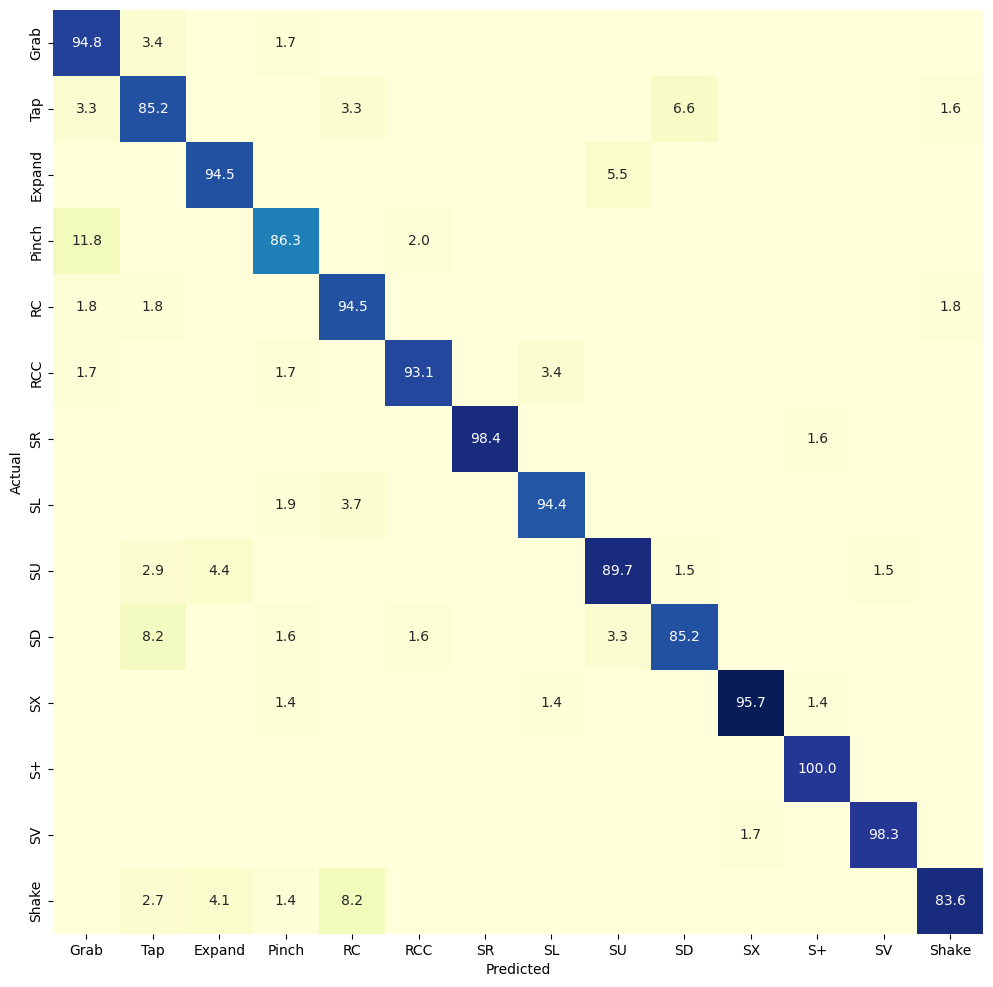

In [33]:
cm_analysis(y_true,y_pred_test, 'images/rlSHREC_14_test3.png', labels_test, ymap=None, figsize=(12,12))